# Problemstellung

Eine Bank möchte die **Kreditwürdigkeit** ihrer Kunden vorhersagen.  
Auf Basis von Kundendaten (z. B. Kontostatus, Kredithistorie, Einkommen, Beschäftigung, Alter, usw.) soll ein Vorhersagemodell entwickelt werden, das jeden Kunden in eine der beiden Klassen einordnet:

- **kreditwürdig (1)**  
- **nicht kreditwürdig (2)**  

Besonderheit ist das von der Bank vorgegebene **Kostenmodell**:  

- Einen *nicht kreditwürdigen Kunden fälschlich als kreditwürdig* einzustufen, verursacht **fünfmal höhere Kosten** als den umgekehrten Fehler (*kreditwürdigen Kunden fälschlich als nicht kreditwürdig*).  

Daraus ergibt sich ein **überwachtes Klassifikationsproblem mit asymmetrischen Fehlkosten**.  

- **Zielvariable (Label):** `Creditworthy`  
- **Eingabeattribute:** Kundendaten wie  
  - Status of existing checking account  
  - Duration  
  - Credit history  
  - Purpose  
  - Credit amount  
  - Employment  
  - Job  
  - Foreign worker  
  - usw.
_________________________

### Datenbereinigung, Transformation und Begründungen

#### 1. Datenbereinigung
- Fehlende Werte (`?`) → `NaN`  
  Grund: Einheitliche Behandlung fehlender Werte; Pandas/Sklearn erwarten `NaN` für Imputation.
- Spalte `foreign_worker` entfernt  
  Grund: Proxy für Nationalität/Migration → Risiko indirekter Diskriminierung; nicht notwendig für Kreditrisikoabschätzung.
- nach deutschem und europäischem Recht ist die Verwendung der Spalte foreign_worker im Kredit-Scoring sehr wahrscheinlich unzulässig, da sie indirekt diskriminierend wirkt (AGG, GG, DSGVO & BDSG, Kreditwesengesetz (KWG), EU-Verbraucherkreditrichtlinie)

#### 2. Transformationen
- Status (aus `personal_status_sex`) → zwei Klassen  
  - Single: A93, A95  
  - Not Single: A91, A92, A94  
  - `personal_status_sex` gelöscht  
  Grund: Geschlecht wurde entfernt, denn es ist ein Verstoß gegen GG, AGG, EU-Gleichbehandlungsrichtlinie (2004/113/EG), DSGVO, und BaFin-Leitlinien; Beziehungsstatus grob behalten (Interpretierbarkeit, weniger sensibel).

- Job → binär  
  - Unskilled: A171, A172  
  - Qualified: A173, A174, A175  
  Grund: Ursprüngliche Kategorien enthalten heikle Infos („resident vs. non-resident“) was ein Proxy für Nationalität ist; dazu fördern seltene Klassen Overfitting.

- Purpose → 3 Klassen  
  - Consumption: A40–A44, A47  
  - Investment/Human Capital: A46, A48, A49  
  - Other/Repairs: A45, A410  
  Grund: Reduktion der Dimensionalität → stabilere Schätzungen, robustere Imputation, bessere Interpretierbarkeit.

#### 3. Ordinale Kodierung (Int64)
- savings → savings_ord: A61=1, A62=2, A63=3, A64=4, A65=0  (amount of savings)
- checking_status → checking_status_ord: A11=1, A12=2, A13=3, A14=0  (amount)
- employment_since → employment_since_ord: A71=0, A72=1, A73=2, A74=3, A75=4  (years)
- credit_history → credit_history_ord: A30=4, A31=3, A32=2, A33=1, A34=0  (Sicherheitsgrad)
Grund: Natürliche Rangordnung; ordinal codiert erhält Monotonie.
`Int64` erlaubt `NaN` und somit sind Berechnungen in diesen Spalten möglich in Pandas.

#### 4. One-Hot / Binär
- debtors → debtors_* (A101, A102, A103)  
- property → property_* (A121, A122, A123, A124)  
- installment_plans → instplan_* (A141, A142, A143)  
- housing → housing_* (A151, A152, A153)  
- telephone → telephone_bin (A191=0, A192=1)  
Grund: Nominalvariablen ohne Ordnung → One-Hot. Binär bei „Telefon: ja/nein“ natürlich.

#### 5. Originale nach Kodierung entfernt
`savings`, `checking_status`, `employment_since`, `credit_history`,  
`debtors`, `property`, `installment_plans`, `housing`, `telephone`,  
sowie Hilfsspalten (`*_cat`).  
Grund: Redundanz und Multikollinearität vermeiden. (Für EDA ggf. vor Drop inspizieren.)

#### 6. Vollständig numerischer Feature-Satz
- Status zusätzlich → Status_bin (Single=1, Not Single=0)  
- Purpose zusätzlich → One-Hot; danach Originale droppen  
Grund: Viele ML-Pipelines erwarten numerische Eingaben. Bei linearen Modellen ggf. Basisdroppen (`drop_first=True`).

---

#### Ergebnis
- Datensatz bereinigt  
- Sensible Merkmale reduziert/entfernt  
- Kategorien verdichtet und kodiert  

Effekte: stabileres Training, geringeres Overfitting, robustere Imputation, bessere Nachvollziehbarkeit.


In [ ]:
import pandas as pd

# === Pfad zur Datendatei ===
FILE_PATH = "kredit.dat"
SAVE_CSV = True
CSV_PATH = "kredit_clean.csv"

# Spaltennamen gemäß Datensatz
colnames = [
    "checking_status",           # A11-A14
    "duration_months",
    "credit_history",            # A30-A34
    "purpose",                   # A40-A410
    "credit_amount",
    "savings",                   # A61-A65
    "employment_since",          # A71-A75
    "installment_rate_pct",
    "personal_status_sex",       # A91-A95
    "debtors",                   # A101-A103
    "residence_since",
    "property",                  # A121-A124
    "age_years",
    "installment_plans",         # A141-A143
    "housing",                   # A151-A153
    "existing_credits",
    "job",                       # A171-A175 (incomplete)
    "dependents",
    "telephone",                 # A191-A192
    "foreign_worker",            # A201-A202 (incomplete)
    "target"                     # 1 = good, 2 = bad
]

# 1) Einlesen & fehlende Werte als NaN erfassen
df = pd.read_csv(
    FILE_PATH,
    sep=r"\s+",
    header=None,
    names=colnames,
    na_values=["?"]
)

# 2) 'foreign_worker' aus ethischen Gründen löschen
if "foreign_worker" in df.columns:
    df = df.drop(columns=["foreign_worker"])

# 3) personal_status_sex -> Status (Single vs. Not Single)
status_map = {"A93": "Single", "A95": "Single", "A91": "Not Single", "A92": "Not Single", "A94": "Not Single"}
df["Status"] = df["personal_status_sex"].map(status_map).astype("category")
df = df.drop(columns=["personal_status_sex"], errors="ignore")

# 4) Job -> binär (Unskilled vs. Qualified) als Kategorie (NaN bleibt NaN)
unskilled = {"A171", "A172"}
qualified = {"A173", "A174", "A175"}
def job_to_binary(code):
    if pd.isna(code): return pd.NA
    code = str(code)
    if code in unskilled: return "Unskilled"
    if code in qualified: return "Qualified"
    return pd.NA
df["job"] = df["job"].apply(job_to_binary).astype("category")

# 5) Purpose -> 3 Stufen (NaN bleibt NaN)
consumption = {"A40", "A41", "A42", "A43", "A44", "A47"}
investment = {"A46", "A48", "A49"}
other_repairs = {"A45", "A410"}
def purpose_to_coarse(code):
    if pd.isna(code): return pd.NA
    code = str(code)
    if code in consumption: return "Consumption"
    if code in investment: return "Investment/Human Capital"
    if code in other_repairs: return "Other/Repairs"
    return pd.NA
df["purpose"] = df["purpose"].apply(purpose_to_coarse).astype("category")

# 6) Ordinale Kodierung (NaN -> <NA> via Int64)
df["savings_ord"]            = df["savings"].map({"A61":1,"A62":2,"A63":3,"A64":4,"A65":0}).astype("Int64")
df["checking_status_ord"]    = df["checking_status"].map({"A11":1,"A12":2,"A13":3,"A14":0}).astype("Int64")
df["employment_since_ord"]   = df["employment_since"].map({"A71":0,"A72":1,"A73":2,"A74":3,"A75":4}).astype("Int64")
df["credit_history_ord"]     = df["credit_history"].map({"A30":4,"A31":3,"A32":2,"A33":1,"A34":0}).astype("Int64")

# 7) One-Hot / binär mit NaN-Durchreichung
def one_hot_with_nan(source_series: pd.Series, prefix: str) -> pd.DataFrame:
    """Erzeugt One-Hot-Dummies in Int64 und setzt bei NaN in der Quelle
    die gesamte Dummy-Zeile auf <NA>, statt auf 0."""
    dums = pd.get_dummies(source_series, prefix=prefix, dtype="Int64")
    mask = source_series.isna()
    if mask.any():
        dums.loc[mask, :] = pd.NA
        # Sicherheits-Recast (stellt sicher, dass Int64 erhalten bleibt):
        dums = dums.astype("Int64")
    return dums

# debtors
df["debtors_cat"] = df["debtors"].map({"A101":"none","A102":"co_applicant","A103":"guarantor"})
df = pd.concat([df, one_hot_with_nan(df["debtors_cat"], "debtors")], axis=1)

# property
df["property_cat"] = df["property"].map({"A121":"Immobilien","A122":"Versicherung","A123":"Auto","A124":"None"})
df = pd.concat([df, one_hot_with_nan(df["property_cat"], "property")], axis=1)

# installment plans
df["installment_plans_cat"] = df["installment_plans"].map({"A141":"bank","A142":"stores","A143":"none"})
df = pd.concat([df, one_hot_with_nan(df["installment_plans_cat"], "instplan")], axis=1)

# housing
df["housing_cat"] = df["housing"].map({"A151":"rent","A152":"own","A153":"free"})
df = pd.concat([df, one_hot_with_nan(df["housing_cat"], "housing")], axis=1)

# telephone (NaN bleibt NaN)
df["telephone_bin"] = df["telephone"].map({"A191":0,"A192":1}).astype("Int64")

# 8) Verbindlich: numerischer Satz für Status & Purpose (mit NaN-Durchreichung)
# Status -> binär (NaN bleibt NaN)
df["Status_bin"] = df["Status"].map({"Single":1, "Not Single":0}).astype("Int64")

# purpose -> One-Hot (NaN bleibt NaN in allen purpose_* Spalten)
purpose_dummies = one_hot_with_nan(df["purpose"], "purpose")
df = pd.concat([df, purpose_dummies], axis=1)

# Optional: job zusätzlich numerisch (NaN bleibt NaN)
df["job_bin"] = df["job"].map({"Unskilled":0, "Qualified":1}).astype("Int64")

# 9) Jetzt ALLE Original-Kategorien in EINEM Schritt droppen
drop_cols = [
    "savings","checking_status","employment_since","credit_history",
    "debtors","property","installment_plans","housing","telephone",
    "debtors_cat","property_cat","installment_plans_cat","housing_cat",
    "Status","purpose","job"
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

# 10) Ausgabe & Speichern
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
print(df.head(10).to_string(index=False))

if SAVE_CSV:
    df.to_csv(CSV_PATH, index=False)
    print(f"\nGespeichert als: {CSV_PATH}")


 duration_months  credit_amount  installment_rate_pct  residence_since  age_years  existing_credits  dependents  target  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
              36           2299                     4                4         39                 1           1       1            3                    0                  <NA>                   2                     0                  0             1              1                    0              0                      0              0              1                0             0            1             0              0           1                 <NA>             

### Explorative Visualisierung numerischer Variablen

Für jede ausgewählte numerische Variable werden zwei Diagramme erstellt:

- **Histogramm** zur Untersuchung der Verteilung (inkl. Dichtekurve)  
- **Boxplot** zur Identifikation möglicher Ausreißer  

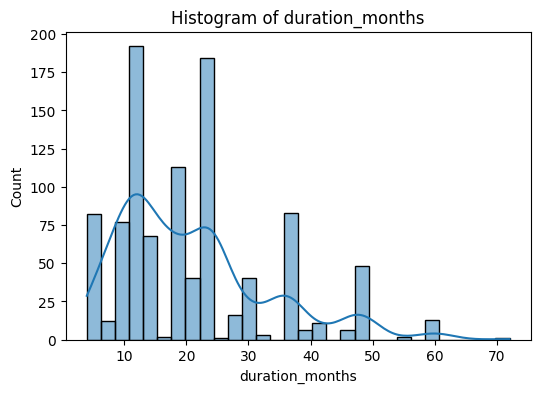

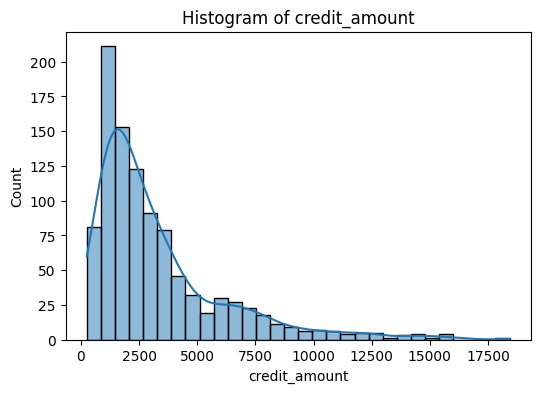

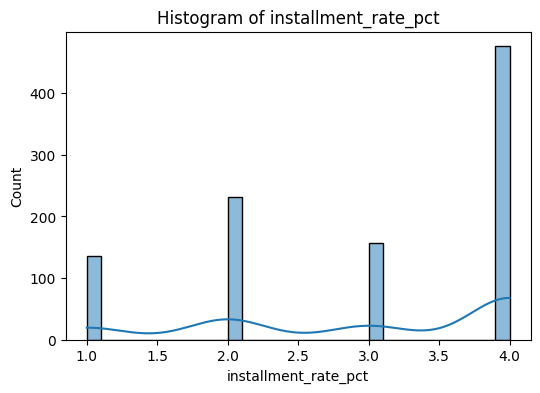

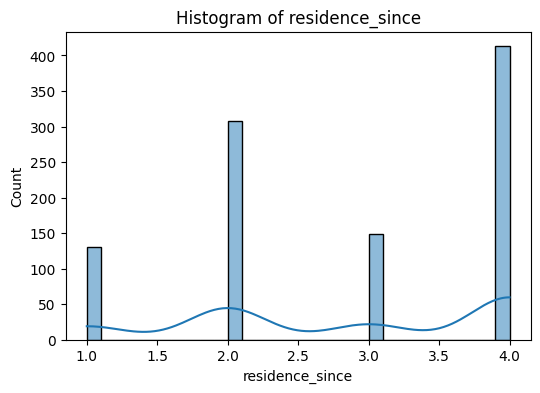

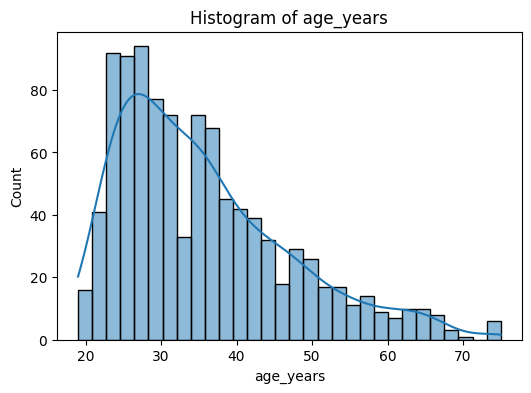

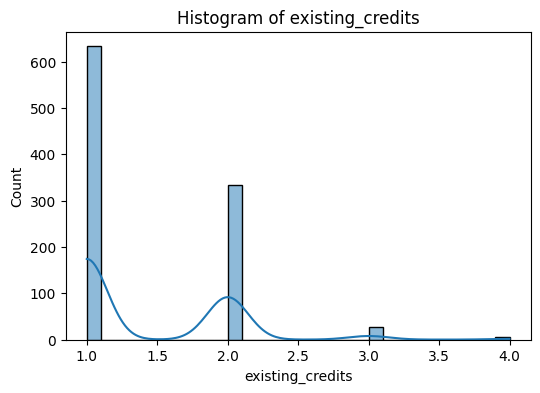

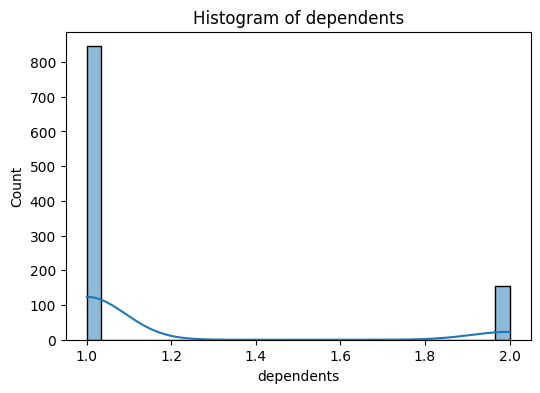

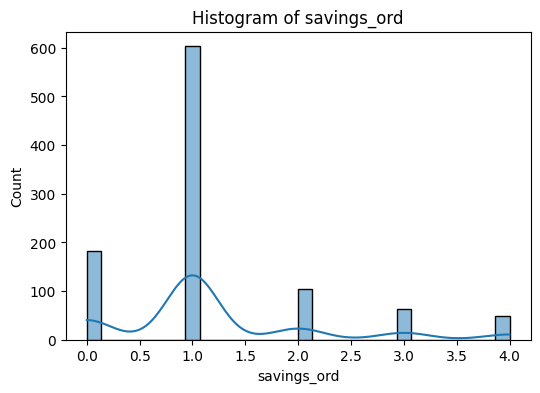

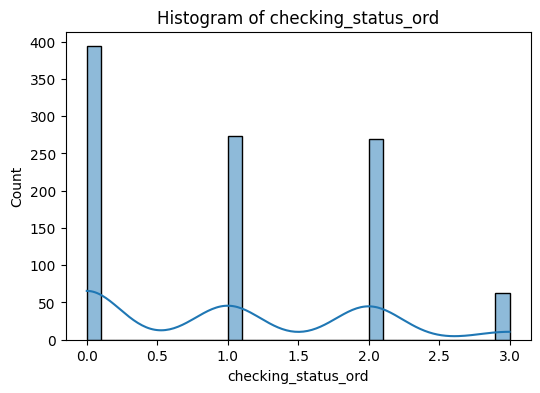

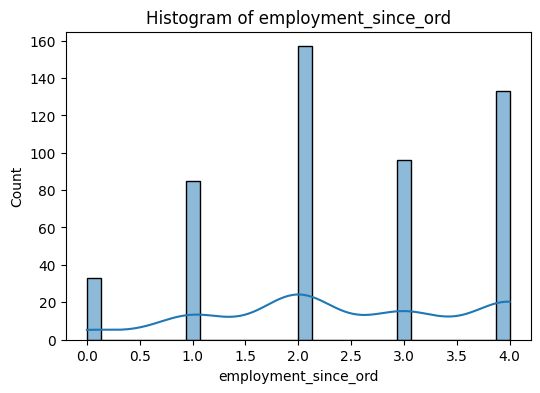

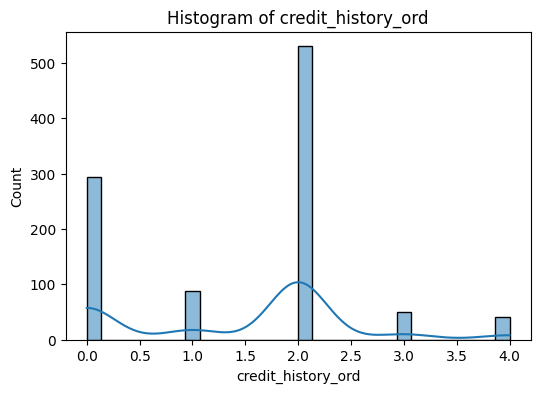

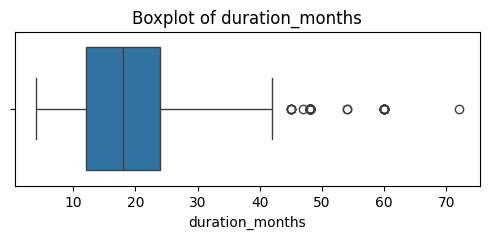

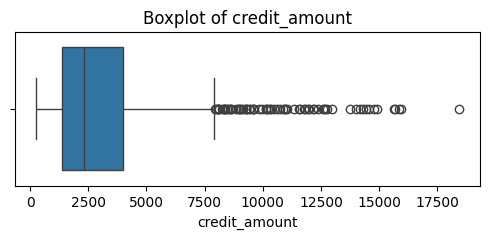

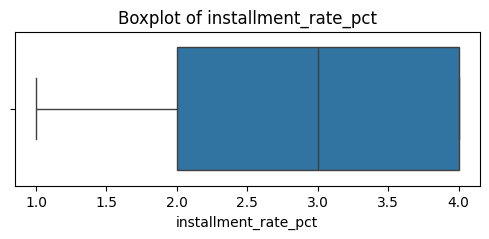

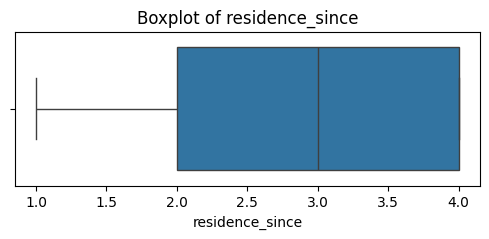

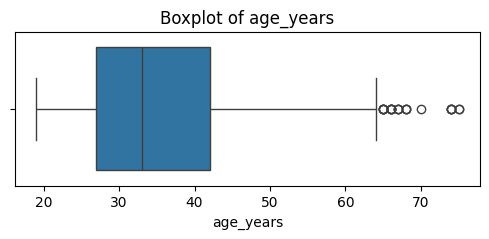

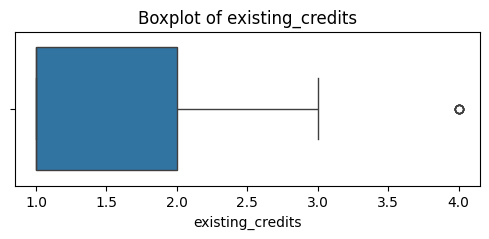

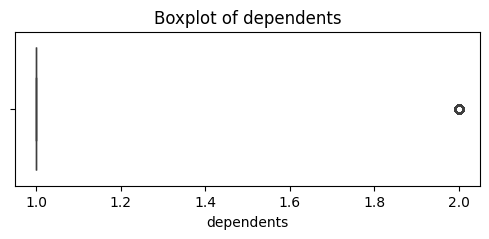

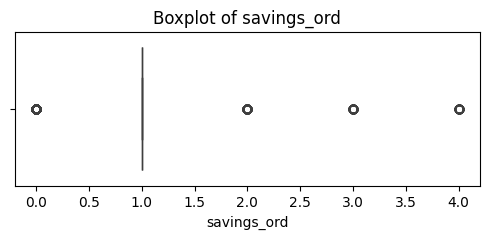

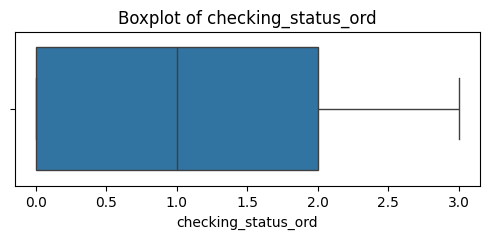

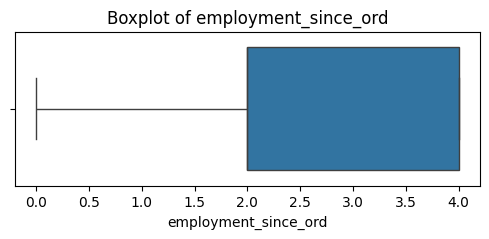

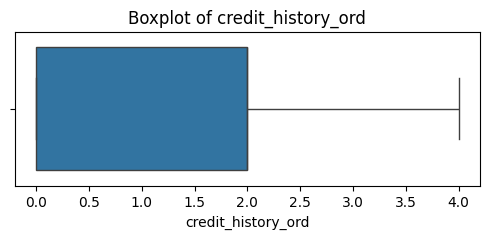

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste der Spalten, die normalisiert werden könnten
numeric_cols = [
    "duration_months",
    "credit_amount",
    "installment_rate_pct",
    "residence_since",
    "age_years",
    "existing_credits",
    "dependents",
    "savings_ord",
    "checking_status_ord",
    "employment_since_ord",
    "credit_history_ord"
]

# Histogramme für jede Variable
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.show()

# Boxplots um Ausreißer zu erkennen
for col in numeric_cols:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.show()

### Datenvorverarbeitung

- CSV-Datei `kredit_clean.csv` wird geladen.  
- Spalten werden nach Typen gruppiert:
  - **Robust-Skalierung** für `credit_amount`  
    - Formel: `z = (x - Median) / IQR`  
      - `IQR = Q3 - Q1`  (Q1 = 25%-Quantil, Q3 = 75%-Quantil)  
    - Warum: Kaum empfindlich gegenüber Ausreißern (sehr großen Kreditbeträgen).

  - **Standard-Skalierung** für kontinuierliche und ordinale Variablen  
    - Formel: `z = (x - Mittelwert) / Standardabweichung`  
    - Ergebnis: Jede Spalte hat ungefähr Mittelwert 0 und Streuung 1.  
    - Warum: Macht Variablen vergleichbar, gut wenn keine starken Ausreißer vorliegen.

  - **Binäre Variablen** bleiben unverändert  
    - Werte sind bereits 0/1; eine Skalierung ist nicht nötig.

- Ein `ColumnTransformer` wendet die passenden Skalierungen spaltenweise an.  
- Das Ergebnis sind skalierte Features, die wieder mit dem Original-DataFrame kombiniert werden.

So entsteht ein einheitlich vorbereiteter Datensatz: robust gegen Ausreißer bei `credit_amount`, normalisiert bei den übrigen numerischen/ordinalen Variablen und unverändert bei 0/1-Indikatoren.


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# CSV laden
df = pd.read_csv("kredit_clean.csv")

# Spalten definieren
robust_cols = ["credit_amount"]

standard_cont_cols = [
    "duration_months",
    "age_years",
    "installment_rate_pct",
    "residence_since",
    "existing_credits",
    "dependents",
]

standard_ordinal_cols = [
    "savings_ord",
    "checking_status_ord",
    "employment_since_ord",
    "credit_history_ord",
]

binary_cols = [
    "debtors_co_applicant", "debtors_guarantor", "debtors_none",
    "property_Auto", "property_Immobilien", "property_None", "property_Versicherung",
    "instplan_bank", "instplan_none", "instplan_stores",
    "housing_free", "housing_own", "housing_rent",
    "telephone_bin", "Status_bin",
    "purpose_Consumption", "purpose_Investment/Human Capital", "purpose_Other/Repairs",
    "job_bin",
]

used_cols = robust_cols + standard_cont_cols + standard_ordinal_cols + binary_cols
X = df[used_cols].copy()

# Pipelines ohne Imputer -> NaN bleibt erhalten
robust_num = Pipeline(steps=[
    ("scale", RobustScaler())
])

standard_cont = Pipeline(steps=[
    ("scale", StandardScaler())
])

standard_ordinal = Pipeline(steps=[
    ("scale", StandardScaler())
])

passthrough_bin = "passthrough"

# ColumnTransformer
preprocess = ColumnTransformer(transformers=[
    ("robust_num", robust_num, robust_cols),
    ("standard_cont", standard_cont, standard_cont_cols),
    ("standard_ordinal", standard_ordinal, standard_ordinal_cols),
    ("bin", passthrough_bin, binary_cols),
], remainder="drop") # Nur zur Sicherheit

# Fit & Transform
X_scaled = preprocess.fit_transform(X) # numpy array

# DataFrame mit Spaltennamen
scaled_cols = robust_cols + standard_cont_cols + standard_ordinal_cols + binary_cols # Namen
X_scaled_df = pd.DataFrame(X_scaled, columns=scaled_cols, index=df.index)

# Alte Spalten raus -> neue Dataframe rein - Target bleibt unberührt
df = pd.concat([df.drop(columns=scaled_cols), X_scaled_df], axis=1)

print(df.head(10).to_string(index=False))


 target  credit_amount  duration_months  age_years  installment_rate_pct  residence_since  existing_credits  dependents  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
      1      -0.007864         1.252574   0.303788              0.918477         1.046987         -0.704926   -0.428290     1.872960            -1.046463                   NaN            0.503428                   0.0                0.0           1.0            1.0                  0.0            0.0                    0.0            0.0            1.0              0.0           0.0          1.0           0.0            0.0         1.0                  NaN             

In [57]:
# Anzahl fehlender Werte je Spalte
missing_counts = df.isna().sum()

# Anteil in Prozent
missing_percent = (df.isna().mean() * 100).round(2)

# Zusammenführen in ein DataFrame
missing_summary = pd.DataFrame({
    "missing_count": missing_counts,
    "missing_percent": missing_percent
})

print(missing_summary.to_string())

                                  missing_count  missing_percent
target                                        0              0.0
credit_amount                                 0              0.0
duration_months                               0              0.0
age_years                                     0              0.0
installment_rate_pct                          0              0.0
residence_since                               0              0.0
existing_credits                              0              0.0
dependents                                    0              0.0
savings_ord                                   0              0.0
checking_status_ord                           0              0.0
employment_since_ord                        496             49.6
credit_history_ord                            0              0.0
debtors_co_applicant                          0              0.0
debtors_guarantor                             0              0.0
debtors_none             

### Imputation Pipeline (Purpose, Job, Employment)

Dieses Skript ersetzt fehlende Werte (`NaN`) in den Spalten **Purpose**, **Job** und **Employment** durch spezialisierte Modelle.  
Die Modelle wurden in dieser Reihenfolge imputiert:
– Erst Purpose, weil die Spalte weniger NaNs hat und deshalb kann sie besser hervorgesagt werden
– Dann Job, weil einfacher binärer Fall und weniger als Employement ist.
– Zuletzt Employment, weil es als Ordinalskala (0–4) auch komplexere Regression braucht und da fehlen so
viele Daten, dass man dafür lieber auch alle Spalten dafür nutzt.

---

#### Purpose
- **Modell**: Multinomiale logistische Regression  
- **Verlustfunktion**: Log-Loss (negative log-likelihood über alle Klassen)
  - Log-Loss passt perfekt, weil er das Modell bestraft, wenn das Modell unsicher ist oder hohe Wahrscheinlichkeit auf die falsche Klasse setzt.
  - Log-Loss ist glatt und differnzierbar.
  - LBFGS: macht das Gleiche wie GD, aber berücksichtigt zusätzlich eine Approximation der Krümmung → effizientere Schritte.
- **Regularisierung**: L2 mit extrem großem `C` (≈ keine Regularisierung)
  - LogLoss + (1/(2*C)) * ||w||^2
- **Grund**:  
  - Multiclass-Klassifikation passt zur kategorialen Zielgröße.  
  - Hohe Treffsicherheit wichtiger als Regularisierung, da es nur um Imputation geht.    

---

#### Job
- **Modell**: Binäre logistische Regression  
- **Verlustfunktion**: Binärer Log-Loss  
- **Regularisierung**: L2 mit sehr großem `C` (≈ keine Regularisierung)  
- **Zusatz**: `class_weight="balanced"` → Ausgleich bei Klassenungleichgewicht  
- **Grund**:  
  - Robustes, schnelles Verfahren für binäre Klassifikation.  
  - Gute Interpretierbarkeit.  
  - „Balanced“ verhindert, dass seltenere Klassen übergangen werden.
  - glatt und differnzierbar Verlustsfunktion 

---

#### Employment
- **Modell**: Ridge-Regression (`RidgeCV` mit Alpha-Grid)  
- **Verlustfunktion**: Quadratischer Fehler (MSE); Auswahl nach Mean Absolute Error (MAE)  
- **Regularisierung**: L2, Stärke (`alpha`) per Cross-Validation bestimmt  
- **Grund**:  
  - Zielvariable ist ordinal (0–4) → Regressionsansatz sinnvoll.  
  - Ridge fügt einen Strafterm hinzu, der große Koeffizienten verhindert:  
    `Objektiv = MSE + alpha * ||w||²`  
  - Dadurch wird das Modell stabiler.  
  - **Alpha** kontrolliert die Stärke: klein → fast normale Regression, groß → stärkere Glättung.
  -ALPHA_GRID_EMP = [10, 1, 0.1] -> Das Modell wählt das beste alpha automatisch per Cross-Validation.  
  - MAE als Auswahlkriterium ist robuster gegen Ausreißer als MSE.  
  - Nach der Vorhersage werden Werte mit `clip_round()` auf {0, 1, 2, 3, 4} gerundet und geclippt → ordinale Konsistenz bleibt erhalten.   

---

#### Evaluation
- Nested Cross-Validation (10-fold)
  - „stratifiziert“ heißt: in jedem Fold haben die Klassen (purpose_cat) die gleiche Verteilung wie im gesamten Datensatz → wichtig bei Klassifikationsproblemen mit ungleichen Häufigkeiten und wurde bei Purpose und Job verwendet
- **Metriken**:
  - Purpose & Job: Accuracy und Precision (weighted)
      - weighted weil die Daten ungleiche Klassenverteilungen haben. Diese Metrik bewertet jede Klasse fairer als Accuracy, berücksichtigt aber trotzdem, wie oft sie tatsächlich vorkommt.
  - Employment: Mean Absolute Error (MAE) und Ordinal Accuracy  
- **Target wurde bewusst nicht genutzt**, um **Data Leakage** zu vermeiden und sicherzustellen, dass die Imputation auch auf neuen, ungelabelten Daten anwendbar bleibt.

---

#### Ergebnisse
- Purpose: Precision ≈ 0.75 | Accuracy ≈ 0.84  
- Job: Precision ≈ 0.80 | Accuracy ≈ 0.70  
- Employment: MAE ≈ 0.57 | Ordinal Accuracy ≈ 0.64  

Die gewählten Modelle liefern **stabile und robuste Ergebnisse** für die Imputation und gewährleisten, dass die Datenbasis konsistent und ohne systematischen Bias bleibt.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression, RidgeCV
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.metrics import mean_absolute_error

# ======================================================================
# Konfiguration
# ======================================================================
RANDOM_STATE = 42
OUTER_FOLDS = 10
BIG_C = 1e10                      # ~keine Regularisierung für LogReg (L2)
C_GRID_EMP = [0.1, 1.0, 10.0]     # für Employment -> alpha_grid = 1/C
ALPHA_GRID_EMP = [1.0 / c for c in C_GRID_EMP]

# ======================================================================
# Hilfsfunktionen
# ======================================================================
def clip_round(arr, low=0, high=4):
    arr = np.rint(arr)
    return np.clip(arr, low, high).astype(int)

def ordinal_acc(y_true, y_pred_cont, low=0, high=4):
    yp = clip_round(y_pred_cont, low, high)
    return (yp == y_true.astype(int)).mean()

def assert_no_nan(df_like, name="X"): # bricht ab, wenn im gegebenen Objekt fehlende Werte sind
    bad = df_like.isna().sum()
    if hasattr(bad, "sum"):
        tot = int(bad.sum())
        assert tot == 0, f"{name} enthält {tot} NaNs:\n{bad[bad>0].sort_values(ascending=False).head(15)}"
    else:
        assert not np.isnan(df_like).any(), f"{name} enthält NaNs."

# ======================================================================
# 0) Datensatz: Annahme df existiert bereits
# ======================================================================
TARGET_COL = "target" if "target" in df.columns else None

purpose_cols = [
    "purpose_Consumption",
    "purpose_Investment/Human Capital",
    "purpose_Other/Repairs",
]

# ======================================================================
# 1) PURPOSE imputieren (multinomiale LogReg ~ohne Regularisierung), zurück in Original-Dummies
# ======================================================================

# Robuste Ableitung von 'purpose_cat' um Zeilen zu bekommen die eine gültige Wert haben
P = df[purpose_cols].astype(float)
row_sum = P.fillna(0).sum(axis=1)
valid = (row_sum == 1)
print(f"[PURPOSE] Zeilen ohne Label (alles 0/NaN): {int((row_sum == 0).sum())}")
print(f"[PURPOSE] Zeilen mit mehr als einer aktiven Klasse: {int((row_sum > 1).sum())}")

df["purpose_cat"] = pd.Series(pd.NA, index=df.index, dtype="object")
df.loc[valid, "purpose_cat"] = P.loc[valid].idxmax(axis=1)
mask_purpose = df["purpose_cat"].notna()

# Ich baue meine Dataframes mit den richtigen Features und gib auch die bekannte Labels zurück
exclude_for_purpose = purpose_cols + ["purpose_cat", "employment_since_ord", "job_bin"]
if TARGET_COL:
    exclude_for_purpose.append(TARGET_COL)
X_purpose = df.loc[mask_purpose, [c for c in df.columns if c not in exclude_for_purpose]]
y_purpose = df.loc[mask_purpose, "purpose_cat"]

assert_no_nan(X_purpose, "X_purpose")
assert_no_nan(y_purpose.to_frame(), "y_purpose")

# Multinomiale LogReg mit lbfgs, l2, riesiges C -> praktisch unregularisiert
logreg_multi = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    penalty="l2",
    C=BIG_C,
    max_iter=2000,
    class_weight=None,           # Fokus auf Precision
    random_state=RANDOM_STATE
)

outer_cv_p = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Reporting: Precision (weighted) + Accuracy
scoring_purpose = {"precision_weighted": "precision_weighted", "accuracy": "accuracy"}
# 1 fold for  tests
cvres_p = cross_validate(logreg_multi, X_purpose, y_purpose, cv=outer_cv_p,
                         scoring=scoring_purpose, n_jobs=-1)
print(
    "[PURPOSE] 10-fold CV  precision_weighted: "
    f"{cvres_p['test_precision_weighted'].mean():.3f} ± {cvres_p['test_precision_weighted'].std():.3f} | "
    f"acc: {cvres_p['test_accuracy'].mean():.3f} ± {cvres_p['test_accuracy'].std():.3f}"
) # gib Mittelwert + Standardabweichung

# Finale Purpose-Imputation
logreg_multi.fit(X_purpose, y_purpose)
if df["purpose_cat"].isna().any():
    X_purpose_missing = df.loc[~mask_purpose, X_purpose.columns]
    assert_no_nan(X_purpose_missing, "X_purpose_missing")
    df.loc[~mask_purpose, "purpose_cat"] = logreg_multi.predict(X_purpose_missing)

# Zurück in die ursprünglichen Dummy-Spalten
df.loc[:, purpose_cols] = 0
for cat in df["purpose_cat"].dropna().unique():
    df.loc[df["purpose_cat"] == cat, cat] = 1
df.drop(columns=["purpose_cat"], inplace=True)
assert_no_nan(df[purpose_cols], "purpose dummy cols")

# ======================================================================
# 2) JOB imputieren (binäre LogReg ~ohne Regularisierung, aber class_weight='balanced')
# ======================================================================
mask_job = df["job_bin"].notna().astype(bool)
exclude_for_job = ["job_bin", "employment_since_ord"]
if TARGET_COL:
    exclude_for_job.append(TARGET_COL)
X_job_cols = [c for c in df.columns if c not in exclude_for_job]
X_job = df.loc[mask_job, X_job_cols]
y_job = df.loc[mask_job, "job_bin"].astype(int)

assert_no_nan(X_job, "X_job")
assert_no_nan(y_job.to_frame(), "y_job")

outer_cv_j = StratifiedKFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)

logreg_bin = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    C=BIG_C,                      # praktisch keine Regularisierung
    max_iter=2000,
    class_weight="balanced",      # hilft bei Imbalance (ohne Laufzeitkosten)
    random_state=RANDOM_STATE
)

scoring_job = {
    "precision_weighted": "precision_weighted",
    "accuracy": "accuracy",
}
cvres_j = cross_validate(logreg_bin, X_job, y_job, cv=outer_cv_j,
                         scoring=scoring_job, n_jobs=-1)
print(
    "[JOB] 10-fold CV  precision_weighted: "
    f"{cvres_j['test_precision_weighted'].mean():.3f} ± {cvres_j['test_precision_weighted'].std():.3f} | "
    f"acc: {cvres_j['test_accuracy'].mean():.3f} ± {cvres_j['test_accuracy'].std():.3f}"
)

# Finale Job-Imputation
logreg_bin.fit(X_job, y_job)
if df["job_bin"].isna().any():
    X_job_missing = df.loc[~mask_job, X_job_cols]
    assert_no_nan(X_job_missing, "X_job_missing")
    df.loc[~mask_job, "job_bin"] = logreg_bin.predict(X_job_missing)

assert df["job_bin"].isna().sum() == 0, "job_bin hat noch Missing-Werte."

# ======================================================================
# 3) EMPLOYMENT imputieren (RidgeCV mit kleinem Alpha-Grid), Reporting MAE & OrdAcc
# ======================================================================
mask_emp = df["employment_since_ord"].notna().astype(bool)
exclude_for_emp = ["employment_since_ord"]
if TARGET_COL:
    exclude_for_emp.append(TARGET_COL)
X_emp_cols = [c for c in df.columns if c not in exclude_for_emp]
X_emp = df.loc[mask_emp, X_emp_cols]
y_emp = df.loc[mask_emp, "employment_since_ord"]

assert_no_nan(X_emp, "X_emp")
assert_no_nan(y_emp.to_frame(), "y_emp")

outer_cv_e = KFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=RANDOM_STATE)
mae_list, ordacc_list = [], []
for tr_idx, te_idx in outer_cv_e.split(X_emp):
    Xtr, Xte = X_emp.iloc[tr_idx], X_emp.iloc[te_idx]
    ytr, yte = y_emp.iloc[tr_idx], y_emp.iloc[te_idx]

    ridge_cv = RidgeCV(alphas=ALPHA_GRID_EMP, scoring="neg_mean_absolute_error", cv=5) # 5-fold inner CV
    ridge_cv.fit(Xtr, ytr)
    ypred = ridge_cv.predict(Xte)

    mae_list.append(mean_absolute_error(yte, ypred))
    ordacc_list.append(ordinal_acc(yte.values, ypred, low=0, high=4))

print(f"[EMPLOYMENT] {OUTER_FOLDS}-fold CV MAE: mean={np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"[EMPLOYMENT] {OUTER_FOLDS}-fold CV Ordinal-Accuracy: mean={np.mean(ordacc_list):.3f} ± {np.std(ordacc_list):.3f}")

# Finale Imputation mit bestem alpha auf allen bekannten Daten
ridge_cv_full = RidgeCV(alphas=ALPHA_GRID_EMP, scoring="neg_mean_absolute_error", cv=5)
ridge_cv_full.fit(X_emp, y_emp)
best_alpha = ridge_cv_full.alpha_
best_C_emp = 1.0 / best_alpha
print(f"[EMPLOYMENT] Best alpha={best_alpha:.6g} -> Best C≈{best_C_emp:.6g}")

if df["employment_since_ord"].isna().any():
    X_emp_missing = df.loc[~mask_emp, X_emp_cols]
    assert_no_nan(X_emp_missing, "X_emp_missing")
    emp_pred = ridge_cv_full.predict(X_emp_missing)
    df.loc[~mask_emp, "employment_since_ord"] = clip_round(emp_pred, low=0, high=4)

# Final sanity checks
assert df[purpose_cols].isna().sum().sum() == 0, "Purpose-Dummies haben NaNs."
assert df["job_bin"].isna().sum() == 0, "job_bin hat NaNs."
assert df["employment_since_ord"].isna().sum() == 0, "employment_since_ord hat NaNs."

print("✓ Imputation abgeschlossen.")


[PURPOSE] Zeilen ohne Label (alles 0/NaN): 173
[PURPOSE] Zeilen mit mehr als einer aktiven Klasse: 0
[PURPOSE] 10-fold CV  precision_weighted: 0.679 ± 0.028 | acc: 0.810 ± 0.012
[JOB] 10-fold CV  precision_weighted: 0.765 ± 0.054 | acc: 0.663 ± 0.055


c:\Users\moham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


[EMPLOYMENT] 10-fold CV MAE: mean=0.748 ± 0.074
[EMPLOYMENT] 10-fold CV Ordinal-Accuracy: mean=0.574 ± 0.053
[EMPLOYMENT] Best alpha=10 -> Best C≈0.1
✓ Imputation abgeschlossen.


In [59]:
print(df.head(10).to_string(index=False))
df.to_csv("kredit_clean.csv", index=False)

 target  credit_amount  duration_months  age_years  installment_rate_pct  residence_since  existing_credits  dependents  savings_ord  checking_status_ord  employment_since_ord  credit_history_ord  debtors_co_applicant  debtors_guarantor  debtors_none  property_Auto  property_Immobilien  property_None  property_Versicherung  instplan_bank  instplan_none  instplan_stores  housing_free  housing_own  housing_rent  telephone_bin  Status_bin  purpose_Consumption  purpose_Investment/Human Capital  purpose_Other/Repairs  job_bin
      1      -0.007864         1.252574   0.303788              0.918477         1.046987         -0.704926   -0.428290     1.872960            -1.046463              1.000000            0.503428                   0.0                0.0           1.0            1.0                  0.0            0.0                    0.0            0.0            1.0              0.0           0.0          1.0           0.0            0.0         1.0                  1.0             

### Feature-Correlation-Analyse

Dieses Skript untersucht die Beziehungen zwischen Merkmalen und Zielvariable. Ziel ist es, **relevante Features zu identifizieren** und **redundante oder irrelevante Merkmale zu entfernen**, um das Modell robuster und effizienter zu machen.  

1. **Korrelation mit Ziel**  
   - Pearson & Spearman Korrelationen werden berechnet.  
   - **Grund:** Pearson erkennt lineare Zusammenhänge, Spearman auch monotone nicht-lineare Beziehungen.  
   - Features mit sehr niedriger Korrelation liefern kaum Information und können entfernt werden, um Rauschen zu vermeiden.  

2. **Multikollinearität**  
   - Stark korrelierte Features untereinander werden erkannt (>=0.9).  
   - **Grund:** Hohe Redundanz führt zu instabilen Koeffizienten (z. B. in linearen Modellen) und erschwert Interpretierbarkeit.  
   - Empfehlung: Nur ein Feature pro Gruppe stark korrelierter Variablen behalten.  

3. **Feature Importance**  
   - ANOVA F-Score und Mutual Information werden berechnet.  
   - **Grund:**  
     - Anova F Score misst, wie stark sich die Verteilungen des Features zwischen den Zielklassen unterscheiden. Hoher Wert → Feature trennt „gute“ und „schlechte“ Kredite gut.
     - Misst, wie viel Information das Feature über das Target liefert (nichtlinear, allgemeiner als Korrelation). Hoher Wert → Feature reduziert Unsicherheit über das Target.  
   - Features mit sehr geringer Wichtigkeit können entfernt werden, um das Modell zu verschlanken.  

4. **Empfehlungen**  
   - Liste mit Features zum Behalten oder Entfernen.
   - Drop = schwach bei mehreren Metriken.
   - Keep = stark bei mindestens einer Metrik.  

5. **Visualisierung**  
   - Darstellung von Top-Korrelationen, Feature-Wichtigkeit, Scatterplots und Keep/Drop-Übersicht.   

➡️ **Ergebnis:** Ein optimierter Datensatz mit **reduzierten und relevanten Features**, der weniger redundant ist, statistisch fundierte Merkmalsauswahl berücksichtigt und so bessere Modellqualität ermöglicht.



Starting comprehensive feature correlation analysis...
FEATURE CORRELATION ANALYSIS FOR BANKING MODEL
Dataset: 1000 samples, 30 features
Target distribution: 700 good (70.0%) / 300 bad (30.0%)

1. CORRELATION WITH TARGET (minimum threshold: 0.05)
--------------------------------------------------
Top correlations with target (Pearson):
                 feature  pearson_corr  pearson_p_value
10    credit_history_ord     -0.228785     2.423060e-13
1        duration_months     -0.214927     6.488050e-12
8    checking_status_ord     -0.197788     2.804819e-10
0          credit_amount     -0.154739     8.797572e-07
22           housing_own      0.134589     1.953064e-05
16         property_None     -0.125750     6.679290e-05
15   property_Immobilien      0.119300     1.559643e-04
9   employment_since_ord      0.116517     2.220048e-04
19         instplan_none      0.113285     3.313488e-04
18         instplan_bank     -0.096510     2.248844e-03

WEAK FEATURES (correlation < 0.05):
  existin

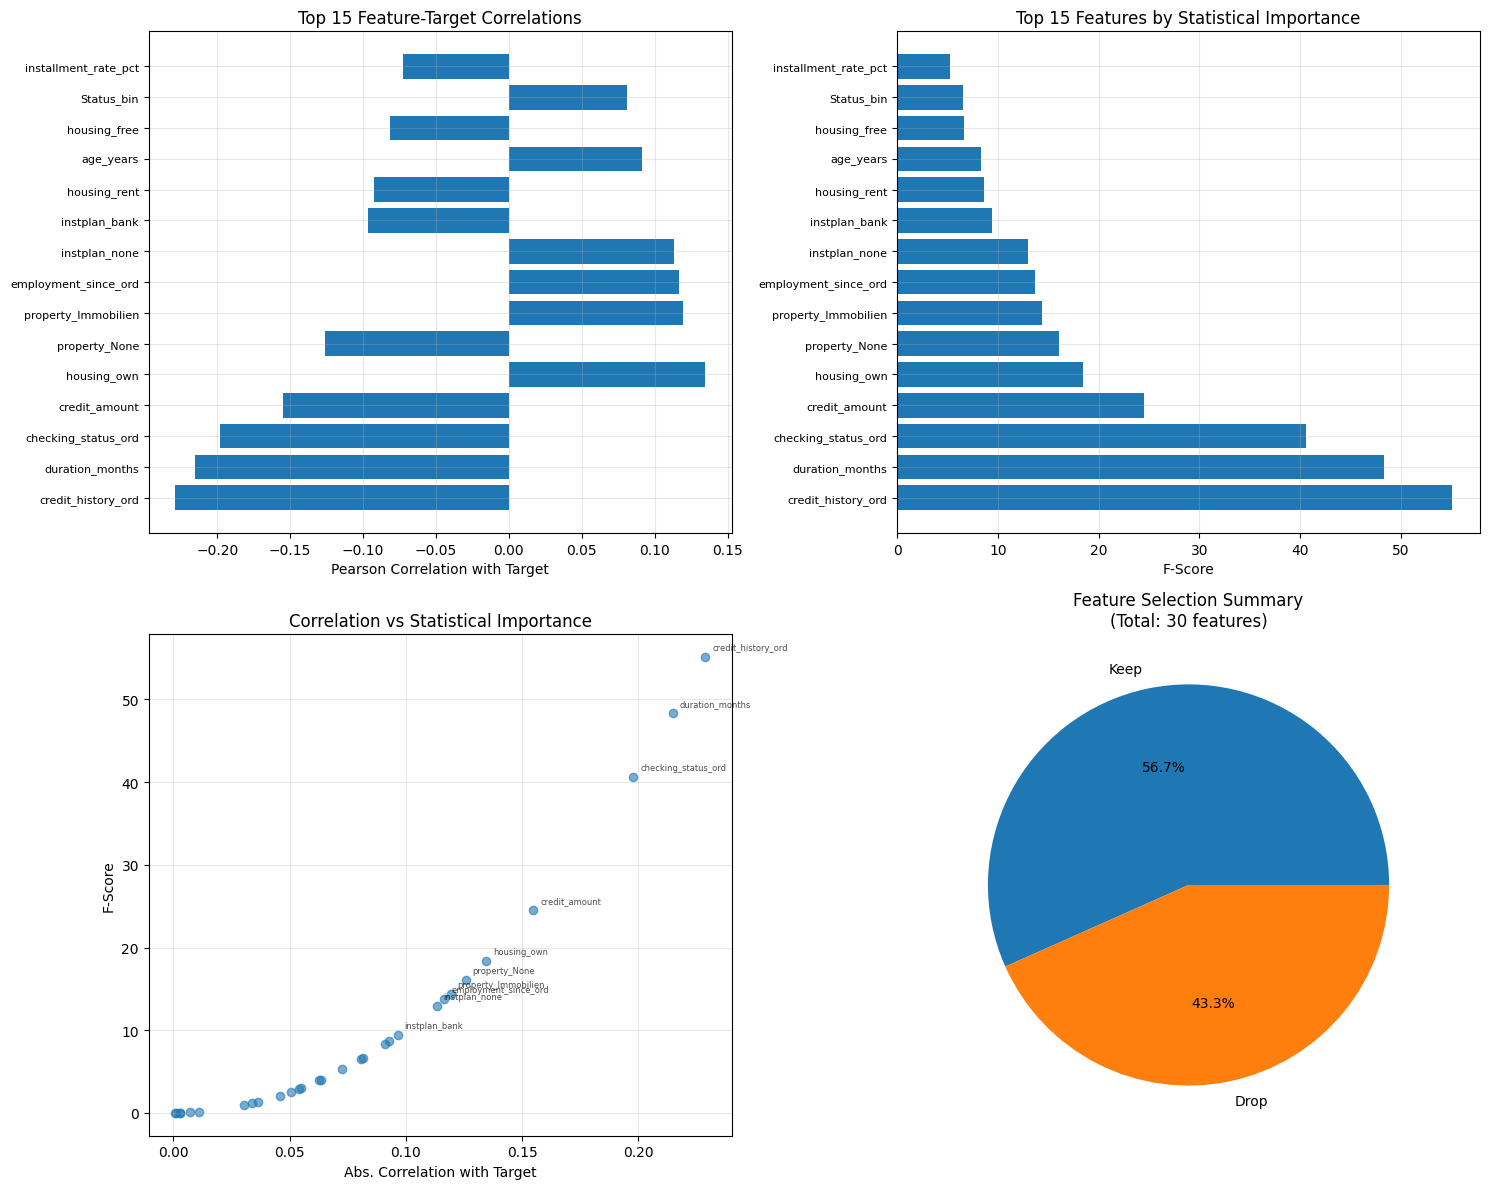


Optimized dataset ready with 17 features!
             feature   f_score    f_p_value  mutual_info
  credit_history_ord 55.123045 2.423060e-13     0.044454
     duration_months 48.333790 6.488050e-12     0.049486
 checking_status_ord 40.631200 2.804819e-10     0.065511
       credit_amount 24.482366 8.797572e-07     0.014959
         housing_own 18.411417 1.953064e-05     0.025704
       property_None 16.035010 6.679290e-05     0.000000
 property_Immobilien 14.408984 1.559643e-04     0.003991
employment_since_ord 13.735514 2.220048e-04     0.018410
       instplan_none 12.974369 3.313488e-04     0.009336
       instplan_bank  9.382968 2.248844e-03     0.000000


In [60]:
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

def analyze_feature_correlations(df, target_col='target', threshold_high=0.9, threshold_target=0.05):
    # Prepare data
    y = (df[target_col] == 1).astype(int).values
    # keep only numeric features for stats below
    X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()

    print("FEATURE CORRELATION ANALYSIS FOR BANKING MODEL")
    print("=" * 60)
    print(f"Dataset: {len(df)} samples, {len(X.columns)} features")
    print(f"Target distribution: {y.sum()} good ({y.mean():.1%}) / {len(y)-y.sum()} bad ({1-y.mean():.1%})")

    results = {}

    # 1) Target correlations
    print(f"\n1. CORRELATION WITH TARGET (minimum threshold: {threshold_target})")
    print("-" * 50)

    target_correlations = []
    for col in X.columns:
        x = X[col].values
        # Guard against constant columns
        if np.all(x == x[0]):
            pearson_corr, pearson_p = 0.0, 1.0
            spearman_corr, spearman_p = 0.0, 1.0
        else:
            pearson_corr, pearson_p = pearsonr(x, y)
            spearman_corr, spearman_p = spearmanr(x, y)

        target_correlations.append({
            'feature': col,
            'pearson_corr': pearson_corr,
            'pearson_p_value': pearson_p,
            'spearman_corr': spearman_corr,
            'spearman_p_value': spearman_p,
            'abs_pearson': abs(pearson_corr),
            'abs_spearman': abs(spearman_corr)
        })

    target_corr_df = pd.DataFrame(target_correlations).sort_values('abs_pearson', ascending=False)
    print("Top correlations with target (Pearson):")
    print(target_corr_df[['feature', 'pearson_corr', 'pearson_p_value']].head(10))

    weak_features = target_corr_df[target_corr_df['abs_pearson'] < threshold_target]['feature'].tolist()
    print(f"\nWEAK FEATURES (correlation < {threshold_target}):")
    for feature in weak_features:
        corr_val = target_corr_df.loc[target_corr_df['feature'] == feature, 'pearson_corr'].iloc[0]
        print(f"  {feature}: {corr_val:.4f}")

    results['target_correlations'] = target_corr_df
    results['weak_features'] = weak_features

    # 2) Multicollinearity
    print(f"\n2. MULTICOLLINEARITY ANALYSIS (threshold: {threshold_high})")
    print("-" * 50)

    corr_matrix = X.corr(numeric_only=True).abs()
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if corr_val >= threshold_high:
                col1 = corr_matrix.columns[i]
                col2 = corr_matrix.columns[j]
                col1_target_corr = abs(target_corr_df.loc[target_corr_df['feature'] == col1, 'pearson_corr'].iloc[0])
                col2_target_corr = abs(target_corr_df.loc[target_corr_df['feature'] == col2, 'pearson_corr'].iloc[0])
                recommend_drop, recommend_keep = (col2, col1) if col1_target_corr > col2_target_corr else (col1, col2)
                high_corr_pairs.append({
                    'feature1': col1, 'feature2': col2, 'correlation': corr_val,
                    'feature1_target_corr': col1_target_corr, 'feature2_target_corr': col2_target_corr,
                    'recommend_drop': recommend_drop, 'recommend_keep': recommend_keep
                })

    if high_corr_pairs:
        high_corr_df = pd.DataFrame(high_corr_pairs)
        print("HIGH CORRELATIONS BETWEEN FEATURES:")
        for _, row in high_corr_df.iterrows():
            print(f"  {row['feature1']} <-> {row['feature2']}: {row['correlation']:.3f}")
            print(f"    Target correlations: {row['feature1_target_corr']:.3f} vs {row['feature2_target_corr']:.3f}")
            print(f"    RECOMMENDATION: Drop {row['recommend_drop']}, Keep {row['recommend_keep']}\n")
        results['multicollinear_features'] = list({p['recommend_drop'] for p in high_corr_pairs})
        results['high_corr_pairs'] = high_corr_df
    else:
        print("No high correlations found between features.")
        results['multicollinear_features'] = []

    # 3) Feature importance
    print(f"\n3. FEATURE IMPORTANCE ANALYSIS")
    print("-" * 50)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    selector_f = SelectKBest(score_func=f_classif, k='all').fit(X_scaled, y)
    selector_mi = SelectKBest(score_func=mutual_info_classif, k='all').fit(X_scaled, y)

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'f_score': selector_f.scores_,
        'f_p_value': selector_f.pvalues_,
        'mutual_info': selector_mi.scores_
    }).sort_values('f_score', ascending=False)

    print("Top features by F-score:")
    print(feature_importance[['feature', 'f_score', 'f_p_value']].head(10))

    low_importance_features = feature_importance[feature_importance['f_p_value'] > 0.05]['feature'].tolist()
    results['feature_importance'] = feature_importance
    results['low_importance_features'] = low_importance_features

    # 4) Final recommendations
    print(f"\n4. FEATURE SELECTION RECOMMENDATIONS")
    print("-" * 50)
    features_to_drop = set(weak_features) | set(results['multicollinear_features']) | set(low_importance_features)
    features_to_keep = [c for c in X.columns if c not in features_to_drop]

    print(f"FEATURES TO DROP ({len(features_to_drop)}):")
    if features_to_drop:
        for f in sorted(features_to_drop):
            reasons = []
            if f in weak_features: reasons.append("weak target correlation")
            if f in results['multicollinear_features']: reasons.append("multicollinearity")
            if f in low_importance_features: reasons.append("low statistical importance")
            print(f"  {f}: {', '.join(reasons)}")
    else:
        print("  None")

    print(f"\nFEATURES TO KEEP ({len(features_to_keep)}):")
    for f in sorted(features_to_keep):
        tc = target_corr_df.loc[target_corr_df['feature'] == f, 'pearson_corr'].iloc[0]
        fs = feature_importance.loc[feature_importance['feature'] == f, 'f_score'].iloc[0]
        print(f"  {f}: target_corr={tc:.3f}, f_score={fs:.1f}")

    results['features_to_drop'] = list(features_to_drop)
    results['features_to_keep'] = features_to_keep

    # 5) Optimized dataset
    df_optimized = df[features_to_keep + [target_col]].copy()
    print(f"\nOPTIMIZED DATASET:")
    print(f"  Original: {df.shape[1]-1} features")
    print(f"  Optimized: {len(features_to_keep)} features")
    print(f"  Reduction: {(df.shape[1]-1) - len(features_to_keep)} features removed")

    results['optimized_dataframe'] = df_optimized
    return results

def plot_correlation_analysis(results, figsize=(15, 12)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    target_corr_df = results['target_correlations'].head(15)
    axes[0,0].barh(range(len(target_corr_df)), target_corr_df['pearson_corr'])
    axes[0,0].set_yticks(range(len(target_corr_df)))
    axes[0,0].set_yticklabels(target_corr_df['feature'], fontsize=8)
    axes[0,0].set_xlabel('Pearson Correlation with Target')
    axes[0,0].set_title('Top 15 Feature-Target Correlations')
    axes[0,0].grid(True, alpha=0.3)

    feature_imp = results['feature_importance'].head(15)
    axes[0,1].barh(range(len(feature_imp)), feature_imp['f_score'])
    axes[0,1].set_yticks(range(len(feature_imp)))
    axes[0,1].set_yticklabels(feature_imp['feature'], fontsize=8)
    axes[0,1].set_xlabel('F-Score')
    axes[0,1].set_title('Top 15 Features by Statistical Importance')
    axes[0,1].grid(True, alpha=0.3)

    merge_df = results['target_correlations'].merge(results['feature_importance'], on='feature')
    axes[1,0].scatter(merge_df['abs_pearson'], merge_df['f_score'], alpha=0.6)
    axes[1,0].set_xlabel('Abs. Correlation with Target')
    axes[1,0].set_ylabel('F-Score')
    axes[1,0].set_title('Correlation vs Statistical Importance')
    axes[1,0].grid(True, alpha=0.3)
    for _, row in merge_df.head(10).iterrows():
        axes[1,0].annotate(row['feature'], (row['abs_pearson'], row['f_score']),
                           xytext=(5,5), textcoords='offset points', fontsize=6, alpha=0.7)

    n_total = len(results['target_correlations'])
    n_keep = len(results['features_to_keep'])
    n_drop = len(results['features_to_drop'])
    axes[1,1].pie([n_keep, n_drop], labels=['Keep', 'Drop'], autopct='%1.1f%%')
    axes[1,1].set_title(f'Feature Selection Summary\n(Total: {n_total} features)')

    plt.tight_layout()
    plt.show()
    return fig

def analyze_and_optimize_features(df, target_col='target', **kwargs):
    """Wrapper: analyze correlations, plot, and return optimized dataset & results."""
    results = analyze_feature_correlations(df, target_col=target_col, **kwargs)
    plot_correlation_analysis(results)
    return results['optimized_dataframe'], results

# --- Usage ---
print("Starting comprehensive feature correlation analysis...")
optimized_df, analysis_results = analyze_and_optimize_features(df, target_col='target')

# Keep artifacts, then intentionally overwrite working df
features_kept     = analysis_results['features_to_keep']
features_dropped  = analysis_results['features_to_drop']
df = optimized_df.copy()
df.to_csv("kredit_final.csv", index=False)

print(f"\nOptimized dataset ready with {df.shape[1]-1} features!")
print(analysis_results['feature_importance'].head(10).to_string(index=False))

### Optimal Banking Model (kurz)

**Ziel**  
Ein **GradientBoosting**-Modell trainieren und nur **sichere Vorhersagen** automatisch treffen  
(**Confidence-Threshold**: p ≥ 0.85 für „good“ bzw. p ≤ 0.15 für „bad“ → sonst manuelle Prüfung).

---

## Regulatorischer Rahmen (EU/DE)
- **DSGVO Art. 22** (Automatisierte Einzelentscheidungen/Profiling):  
  Banken müssen aussagekräftige Informationen über die involvierte Logik liefern (Erklärbarkeit).
- **Verbraucherschutz (z. B. Verbraucherkreditrichtlinie)**:  
  **Begründungspflicht** bei Ablehnung/verschlechterten Konditionen.
- **Aufsicht (BaFin/EBA/ECB)**:  
  Modelle müssen nachvollziehbar, prüfbar, auditierbar und monitorbar sein (Modellrisikomanagement).
- **Implikation**: Bevorzugt erklärbare Pipelines (Gradient Boosting/LightGBM mit Feature-Attribution, LogReg),  
  klare Dokumentation & stabile Metriken (AUC/PR-AUC/KS/Gini), **Fairness-/Bias-Checks**.

---

## Vorgehen (Workflow)
1. **Datenaufbereitung**
   - Zielvariable: `y ∈ {0=bad, 1=good}`  
   - Features: skaliert/enkodiert; Leaks ausgeschlossen; Train/Valid-Splits (CV).
2. **Hyperparameter-Tuning**  
   - `GridSearchCV(cv=3, scoring='roc_auc')` auf **GradientBoostingClassifier**.
3. **Training & Confidence-Filter**
   - Trainiere bestes Modell (aus Grid).  
   - **Automatisiere** Fälle mit hoher Sicherheit:  
     - `p ≥ 0.85` → Vorhersage `1` (good)  
     - `p ≤ 0.15` → Vorhersage `0` (bad)  
     - sonst `-1` (**Abstain** → manuelle Prüfung)
4. **Evaluation**
   - **Overall** (alle Fälle): ROC-AUC, PR-AUC (Average Precision), KS, Gini.  
   - **Confident-Subset** (nur automatisierte Fälle): Accuracy, Balanced Accuracy, ROC-AUC, PR-AUC, KS, **Kosten** `5×FP + 1×FN`.  
   - **Coverage** = Anteil der Fälle mit automatischer Entscheidung.
5. **Cross-Validation**
   - `StratifiedKFold(k=5)` → Mittelwert ± Std. für **Coverage & Confident-Metriken**.
6. **Persistenz & Reporting**
   - `joblib.dump`/`load`.  
   - **Business-Summary**: Automatisierungsquote, erwartete Genauigkeit, FP/FN-Kosten, manuelle Restfälle.

---

## Modelle & Hyperparameter (Grid)
| Komponente | Parameter (Beispiel-Grid) | Zweck |
|---|---|---|
| GradientBoostingClassifier | `n_estimators ∈ {100,200}`, `learning_rate ∈ {0.05,0.1}`, `max_depth ∈ {3,5}`, `min_samples_split ∈ {2,5}`, `min_samples_leaf ∈ {1,2}` | Kapazität, Regularisierung, Bias/Varianz-Trade-off |
| (Optional) LogisticRegression (Baseline) | `C ∈ {0.01,0.1,1,10,100}`, `penalty ∈ {l1,l2}`, `solver='liblinear'` | Vergleichbarkeit/Erklärbarkeit |
| (Optional) LightGBM | `n_estimators, learning_rate, num_leaves, min_child_samples, subsample, colsample_bytree` | Performance-Benchmark |

> Hinweis: Trees brauchen keinen Scaler; in einer einheitlichen Pipeline schadet er aber nicht.

---

## Metriken (Definition & Nutzung)
- **Coverage**: Anteil der automatisch getroffenen Entscheidungen.  
- **Confident-Accuracy / Balanced-Accuracy**: Qualität **nur** auf automatisierten Fällen.  
- **ROC-AUC / Gini (2·AUC−1)**: Ranking-Qualität.  
- **PR-AUC (Average Precision)**: robust bei **Klassenungleichgewicht**.  
- **KS** (Kolmogorov-Smirnov): bankübliches Trennmaß.  
- **Kosten**: `Cost = 5×FP + 1×FN` (gewichteter Fehler-Proxy, anpassbar).

---

## Entscheidungsregeln (Banking-Tauglichkeit)
- **Mindestanforderung** (Beispiel):  
  - **Confident-Accuracy ≥ 80 %** **und** **Coverage ≥ 25 %**.  
- **Threshold-Sweep**: τ ∈ {0.70, 0.80, 0.85, 0.90} → Wähle (Modell, τ) mit bestmöglichem **Trade-off** aus Accuracy/PR-AUC/KS und Coverage.  
- **Fallback**: Niedrige Coverage → mehr manuelle Prüfungen; ggf. **Kalibrierung** (Platt/Isotonic) und **Threshold-Tuning** (Youden-J, Kostenminimum).

---

## Kernfunktionen (API-Skizze)
- train_with_hyperparameter_tuning(X, y) → model, best_params  
- predict_with_confidence(model, X, threshold=0.85) → y_pred, probas, mask_confident 
- evaluate_model(model, X_test, y_test, threshold=0.85) → {coverage, confident_accuracy, …, cost}
- cross_validate_performance(X, y, threshold=0.85) → CV-Tabellen (Mittel ± Std.)
- save_model(model, path) / load_model(path)  
- get_business_summary(X, y, model, threshold=0.85) → Automatisierungsquote, erwartete Treffer, Kosten, manuelle Restlast  
- train_optimal_banking_model(df) → End-to-End-Pipeline

---

## Output
- **Trainiertes Pipeline-Modell** + **beste Hyperparameter**  
- **CV-Übersicht** (Confident-Accuracy, Coverage, AUC/PR-AUC/KS/Gini, Kosten)  
- **Business-Impact**: automatisierter Anteil, erwartete Genauigkeit, **FP/FN-Kosten**, manuelle Restfälle


In [3]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix,
    average_precision_score, roc_curve 
)
import lightgbm as lgb
import numpy as np
import pandas as pd
import warnings

# Filter specific warnings if needed
warnings.filterwarnings('ignore', category=UserWarning)

df = pd.read_csv("kredit_final.csv")


class ConfidentBankingModel:
    def __init__(self, confidence_threshold=0.8, min_coverage=0.3):
        """
        confidence_threshold: Minimum probability to make a prediction (0.8 = 80%)
        min_coverage: Minimum fraction of cases we must be able to predict
        """
        self.confidence_threshold = confidence_threshold
        self.min_coverage = min_coverage
        self.models = {}
        
    def evaluate_with_confidence(self, model, X_test, y_test):
        """Evaluate model only on high-confidence predictions"""
        # Get probability predictions
        if hasattr(model, 'predict_proba'):
            probas = model.predict_proba(X_test)[:, 1]
        else:
            # For models without predict_proba, use decision_function
            scores = model.decision_function(X_test)
            probas = 1 / (1 + np.exp(-scores))  # Sigmoid transform

        # -------- OVERALL-Metriken (alle Fälle, ohne Abstain) --------
        if len(np.unique(y_test)) > 1:
            overall_auc = roc_auc_score(y_test, probas)
            overall_pr_auc = average_precision_score(y_test, probas)  # PR-AUC (POR)
            fpr_all, tpr_all, _ = roc_curve(y_test, probas)
            overall_ks = float(np.max(tpr_all - fpr_all))  # KS-Statistik
        else:
            overall_auc = overall_pr_auc = overall_ks = np.nan
        # --------------------------------------------------------------

        # Find high-confidence predictions
        high_confidence_mask = (probas >= self.confidence_threshold) | (probas <= (1 - self.confidence_threshold))
        
        # immer 'confusion_matrix' & neue Keys zurückgeben
        if np.sum(high_confidence_mask) == 0:
            return {
                'coverage': 0.0,
                'confident_accuracy': 0.0,
                'confident_balanced_accuracy': 0.0,
                'confident_auc': np.nan,            # NaN statt 0.0, um Ø nicht zu verfälschen
                'total_samples': len(X_test),
                'confident_samples': 0,
                'confident_predictions': np.array([]),
                'confident_true_labels': np.array([]),
                'all_probabilities': probas,
                'confusion_matrix': None,
                'confident_pr_auc': np.nan,         
                'confident_ks': np.nan,             
                'confident_gini': np.nan,           
                'overall_auc': overall_auc,         
                'overall_pr_auc': overall_pr_auc,   
                'overall_ks': overall_ks            
            }
        # -------------------------------------------------------------------

        # Get confident predictions - ensure we work with numpy arrays
        if hasattr(X_test, 'iloc'):  # pandas DataFrame
            X_confident = X_test.iloc[high_confidence_mask]
        else:  # numpy array
            X_confident = X_test[high_confidence_mask]
            
        if hasattr(y_test, 'iloc'):  # pandas Series
            y_confident = y_test.iloc[high_confidence_mask].values
        else:  # numpy array
            y_confident = y_test[high_confidence_mask]
            
        probas_confident = probas[high_confidence_mask]
        
        # Make predictions for confident cases
        predictions_confident = (probas_confident >= 0.5).astype(int)
        
        # Calculate metrics only for confident predictions
        coverage = np.sum(high_confidence_mask) / len(X_test)
        confident_accuracy = accuracy_score(y_confident, predictions_confident)
        confident_balanced_accuracy = balanced_accuracy_score(y_confident, predictions_confident)
        
        # AUC nur, wenn beide Klassen vorhanden sind
        if len(np.unique(y_confident)) > 1:
            confident_auc = roc_auc_score(y_confident, probas_confident)
        else:
            confident_auc = np.nan

        # PR-AUC (POR) & KS fürs confident-Subset
        if len(np.unique(y_confident)) > 1:
            confident_pr_auc = average_precision_score(y_confident, probas_confident)
            fpr, tpr, _ = roc_curve(y_confident, probas_confident)
            confident_ks = float(np.max(tpr - fpr))
        else:
            confident_pr_auc = np.nan
            confident_ks = np.nan

        # Gini aus ROC-AUC
        confident_gini = (2 * confident_auc - 1) if not np.isnan(confident_auc) else np.nan
            
        # Confusion Matrix (für confident-Fälle)
        if len(y_confident) > 0:
            conf_matrix = confusion_matrix(y_confident, predictions_confident)
        else:
            conf_matrix = None
            
        return {
            'coverage': coverage,
            'confident_accuracy': confident_accuracy,
            'confident_balanced_accuracy': confident_balanced_accuracy,
            'confident_auc': confident_auc,
            'total_samples': len(X_test),
            'confident_samples': np.sum(high_confidence_mask),
            'confident_predictions': predictions_confident,
            'confident_true_labels': y_confident,
            'all_probabilities': probas,
            'confusion_matrix': conf_matrix,
            'confident_pr_auc': confident_pr_auc,   
            'confident_ks': confident_ks,           
            'confident_gini': confident_gini,       
            'overall_auc': overall_auc,             
            'overall_pr_auc': overall_pr_auc,       
            'overall_ks': overall_ks                
        }
    
    def cross_validate_with_confidence(self, X, y, model_configs, cv_folds=5):
        """Cross-validation with confidence-based evaluation"""
        
        results = []
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        for model_name, model_config in model_configs.items():
            print(f"\nEvaluating {model_name} with confidence threshold {self.confidence_threshold}")
            
            fold_results = []
            
            for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
                # Handle both DataFrame and numpy array inputs
                if hasattr(X, 'iloc'):
                    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                else:
                    X_train, X_test = X[train_idx], X[test_idx]
                    
                if hasattr(y, 'iloc'):
                    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                else:
                    y_train, y_test = y[train_idx], y[test_idx]
                
                # Grid search for best parameters
                grid_search = GridSearchCV(
                    model_config['pipeline'],
                    model_config['param_grid'],
                    cv=3,
                    scoring='roc_auc',
                    n_jobs=-1
                )
                
                grid_search.fit(X_train, y_train)
                best_model = grid_search.best_estimator_
                
                # Evaluate with confidence - ensure y_test is numpy array
                y_test_values = y_test.values if hasattr(y_test, 'values') else y_test
                confidence_results = self.evaluate_with_confidence(best_model, X_test, y_test_values)
                
                fold_result = {
                    'model': model_name,
                    'fold': fold,
                    'coverage': confidence_results['coverage'],
                    'confident_accuracy': confidence_results['confident_accuracy'],
                    'confident_balanced_accuracy': confidence_results['confident_balanced_accuracy'],
                    'confident_auc': confidence_results['confident_auc'],
                    'total_samples': confidence_results['total_samples'],
                    'confident_samples': confidence_results['confident_samples'],
                    'best_params': grid_search.best_params_
                }

                # weitere Metriken in die Fold-Resultate aufnehmen
                for k in ('confident_pr_auc', 'confident_ks', 'confident_gini',
                          'overall_auc', 'overall_pr_auc', 'overall_ks'):
                    fold_result[k] = confidence_results.get(k, np.nan)
                
                # defensive CM access
                cm = confidence_results.get('confusion_matrix')
                if cm is not None and getattr(cm, 'size', 0) == 4:
                    tn, fp, fn, tp = cm.ravel()
                    cost_5xFP_1xFN = 5 * fp + 1 * fn
                    fold_result['confident_cost_5xFP_1xFN'] = cost_5xFP_1xFN
                    fold_result['confident_FP'] = fp
                    fold_result['confident_FN'] = fn
                else:
                    fold_result['confident_cost_5xFP_1xFN'] = np.nan
                    fold_result['confident_FP'] = np.nan
                    fold_result['confident_FN'] = np.nan
                # ---------------------------------------------------
                
                fold_results.append(fold_result)
                
                print(f"  Fold {fold}: Coverage={confidence_results['coverage']:.3f}, "
                      f"Confident Accuracy={confidence_results['confident_accuracy']:.3f}, "
                      f"Samples={confidence_results['confident_samples']}/{confidence_results['total_samples']}")
            
            results.extend(fold_results)
        
        return pd.DataFrame(results)
    
    def get_model_configs(self):
        """Define model configurations"""
        return {
            'LogisticRegression': {
                'pipeline': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', LogisticRegression(random_state=42, max_iter=1000))
                ]),
                'param_grid': {
                    'clf__C': [0.01, 0.1, 1, 10, 100],
                    'clf__penalty': ['l1', 'l2'],
                    'clf__solver': ['liblinear']
                }
            },
            'GBDT_LightGBM': {
                'pipeline': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', lgb.LGBMClassifier(random_state=42, verbose=-1))
                ]),
                'param_grid': {
                    'clf__n_estimators': [100, 200],
                    'clf__learning_rate': [0.05, 0.1, 0.15],
                    'clf__num_leaves': [31, 63],
                    'clf__min_child_samples': [10, 20],
                    'clf__subsample': [0.8, 1.0],
                    'clf__colsample_bytree': [0.8, 1.0]
                }
            },
            'GradientBoosting': {
                'pipeline': Pipeline([
                    ('scaler', StandardScaler()),
                    ('clf', GradientBoostingClassifier(random_state=42))
                ]),
                'param_grid': {
                    'clf__n_estimators': [100, 200],
                    'clf__learning_rate': [0.05, 0.1],
                    'clf__max_depth': [3, 5],
                    'clf__min_samples_split': [2, 5],
                    'clf__min_samples_leaf': [1, 2]
                }
            }
        }


# Usage example:
def run_confident_banking_analysis(X, y, confidence_thresholds=[0.7, 0.8, 0.9]):
    """
    Run analysis with different confidence thresholds
    """
    all_results = []
    
    for conf_threshold in confidence_thresholds:
        print(f"\n{'='*60}")
        print(f"ANALYSIS WITH CONFIDENCE THRESHOLD: {conf_threshold}")
        print(f"{'='*60}")
        
        banking_model = ConfidentBankingModel(confidence_threshold=conf_threshold)
        model_configs = banking_model.get_model_configs()
        
        # Run cross-validation
        results_df = banking_model.cross_validate_with_confidence(X, y, model_configs)
        results_df['confidence_threshold'] = conf_threshold
        
        # Summary statistics
        summary = results_df.groupby('model').agg({
            'coverage': 'mean',
            'confident_accuracy': 'mean',
            'confident_balanced_accuracy': 'mean',
            'confident_auc': 'mean',
            'confident_pr_auc': 'mean',   # NEU (POR)
            'confident_ks': 'mean',       # NEU
            'confident_gini': 'mean',     # NEU
            'overall_auc': 'mean',        # NEU
            'overall_pr_auc': 'mean',     # NEU
            'overall_ks': 'mean',         # NEU
            'confident_samples': 'mean',
            'confident_cost_5xFP_1xFN': 'mean',
            'confident_FP': 'mean',
            'confident_FN': 'mean'
        }).round(3)
        
        print(f"\nSUMMARY FOR CONFIDENCE THRESHOLD {conf_threshold}:")
        print(summary)
        
        # Check if coverage is acceptable
        min_coverage = summary['coverage'].min()
        if min_coverage < 0.3:
            print(f"\n⚠️  WARNING: Minimum coverage is {min_coverage:.3f}, below 30% threshold!")
        else:
            print(f"\n✅ Coverage acceptable: minimum {min_coverage:.3f}")
        
        # Find best model for this threshold (weiterhin via Accuracy)
        best_model_idx = summary['confident_accuracy'].idxmax()
        best_accuracy = summary.loc[best_model_idx, 'confident_accuracy']
        best_coverage = summary.loc[best_model_idx, 'coverage']
        
        print(f"\n🏆 Best model: {best_model_idx}")
        print(f"   Confident Accuracy: {best_accuracy:.3f}")
        print(f"   Coverage: {best_coverage:.3f}")
        print(f"   Average confident samples per fold: {summary.loc[best_model_idx, 'confident_samples']:.0f}")
        
        if best_accuracy >= 0.85 and best_coverage >= 0.3:
            print(f"   ✅ SUITABLE FOR BANKING: High accuracy ({best_accuracy:.3f}) with acceptable coverage!")
        elif best_accuracy >= 0.85:
            print(f"   ⚠️  High accuracy but low coverage ({best_coverage:.3f})")
        else:
            print(f"   ❌ Accuracy still too low for banking ({best_accuracy:.3f})")
        
        all_results.append(results_df)
    
    return pd.concat(all_results, ignore_index=True)


# Data preparation function
def prepare_banking_data(df):
    """
    Prepare data from dataframe with target column
    """
    # Check if target column exists
    if 'target' not in df.columns:
        raise ValueError("DataFrame must contain a 'target' column")
    
    # Mapping: target {1,2} -> 1 = good, 0 = bad
    y = (df['target'] == 1).astype(int)
    X = df.drop(columns=['target']).copy()
    
    print(f"Data prepared:")
    print(f"  Total samples: {len(df)}")
    print(f"  Features: {X.shape[1]}")
    print(f"  Target distribution:")
    print(f"    Good credit (1): {y.sum()} ({y.mean():.2%})")
    print(f"    Bad credit (0): {len(y) - y.sum()} ({1-y.mean():.2%})")
    
    return X, y


# Complete workflow function
def analyze_banking_model(df, confidence_thresholds=[0.7, 0.8, 0.85, 0.9]):
    """
    Complete analysis workflow from dataframe to results
    """
    print("🏦 BANKING MODEL ANALYSIS WITH CONFIDENCE-BASED PREDICTIONS")
    print("=" * 70)
    
    # Prepare data
    X, y = prepare_banking_data(df)
    
    # Run analysis with different confidence thresholds
    results = run_confident_banking_analysis(X, y, confidence_thresholds)
    
    # Find best overall configuration
    print(f"\n{'='*70}")
    print("🏆 BEST CONFIGURATION SUMMARY")
    print("=" * 70)
    
    # Filter für Summary (hier kannst du weitere Metriken ergänzen)
    good_results = results.groupby(['model', 'confidence_threshold']).agg({
        'coverage': 'mean',
        'confident_accuracy': 'mean',
        'confident_balanced_accuracy': 'mean',
        'confident_auc': 'mean',
        'confident_pr_auc': 'mean',     # NEU
        'overall_auc': 'mean',          # NEU
        'overall_pr_auc': 'mean',       # NEU
        'confident_cost_5xFP_1xFN': 'mean'
    }).round(3)
    
    # Filter for banking standards
    banking_suitable = good_results[
        (good_results['confident_accuracy'] >= 0.80) & 
        (good_results['coverage'] >= 0.25)
    ].copy()
    
    if len(banking_suitable) > 0:
        print("✅ BANKING-SUITABLE CONFIGURATIONS FOUND:")
        banking_suitable_sorted = banking_suitable.sort_values(
            ['confident_accuracy', 'coverage'], 
            ascending=[False, False]
        )
        print(banking_suitable_sorted)
        
        # Best configuration
        best_config = banking_suitable_sorted.index[0]
        best_model, best_threshold = best_config
        best_stats = banking_suitable_sorted.iloc[0]
        
        print(f"\n🥇 RECOMMENDED CONFIGURATION:")
        print(f"   Model: {best_model}")
        print(f"   Confidence Threshold: {best_threshold}")
        print(f"   Confident Accuracy: {best_stats['confident_accuracy']:.3f}")
        print(f"   Coverage: {best_stats['coverage']:.3f}")
        print(f"   AUC (confident): {best_stats['confident_auc']:.3f}")
        print(f"   PR-AUC/POR (confident): {best_stats['confident_pr_auc']:.3f}")
        print(f"   AUC (overall): {best_stats['overall_auc']:.3f}")
        print(f"   PR-AUC/POR (overall): {best_stats['overall_pr_auc']:.3f}")
        print(f"   Cost Score (5×FP+1×FN): {best_stats['confident_cost_5xFP_1xFN']:.1f}")
        
        coverage_pct = best_stats['coverage'] * 100
        auto_cases = int(len(df) * best_stats['coverage'])
        manual_cases = len(df) - auto_cases
        
        print(f"\n📊 PRACTICAL IMPACT:")
        print(f"   • {auto_cases:,} cases automated ({coverage_pct:.1f}%)")
        print(f"   • {manual_cases:,} cases for human review")
        print(f"   • Expected accuracy on automated cases: {best_stats['confident_accuracy']:.1%}")
        
    else:
        print("❌ NO CONFIGURATIONS MEET BANKING STANDARDS")
        print("   (Need: Confident Accuracy ≥80% AND Coverage ≥25%)")
        print("\n📋 All results:")
        print(good_results.sort_values('confident_accuracy', ascending=False))
        
        print(f"\n💡 RECOMMENDATIONS:")
        print("   1. Improve feature engineering")
        print("   2. Collect more/better training data")
        print("   3. Try ensemble methods")
        print("   4. Consider lower confidence thresholds")
    
    return results


# Example usage and automatic execution
if __name__ == "__main__":
    print("✅ Banking Model Analysis")
    print("\n🚀 TO RUN:")
    print("results = analyze_banking_model(df)")
    
    # Try to run automatically if df exists in globals
    try:
        if 'df' in globals():
            print("\n✅ Found 'df' variable, starting analysis...")
            results = analyze_banking_model(df)
            print(f"\n✅ Analysis complete! Results stored in 'results' variable.")
        else:
            print("\n📝 Note: 'df' variable not found - waiting for manual execution")
    except Exception as e:
        print(f"❌ Error during analysis: {str(e)}")
        print("Please check your data and run manually: results = analyze_banking_model(df)")
    
    print("\n" + "="*50)
    print("ANALYSIS FUNCTIONS AVAILABLE:")
    print("• analyze_banking_model(df) - Complete analysis")
    print("• prepare_banking_data(df) - Just prepare X,y") 
    print("="*50)


✅ Banking Model Analysis

🚀 TO RUN:
results = analyze_banking_model(df)

✅ Found 'df' variable, starting analysis...
🏦 BANKING MODEL ANALYSIS WITH CONFIDENCE-BASED PREDICTIONS
Data prepared:
  Total samples: 1000
  Features: 17
  Target distribution:
    Good credit (1): 700 (70.00%)
    Bad credit (0): 300 (30.00%)

ANALYSIS WITH CONFIDENCE THRESHOLD: 0.7

Evaluating LogisticRegression with confidence threshold 0.7
  Fold 1: Coverage=0.375, Confident Accuracy=0.933, Samples=75/200
  Fold 2: Coverage=0.375, Confident Accuracy=0.853, Samples=75/200
  Fold 3: Coverage=0.415, Confident Accuracy=0.843, Samples=83/200
  Fold 4: Coverage=0.300, Confident Accuracy=0.917, Samples=60/200
  Fold 5: Coverage=0.305, Confident Accuracy=0.918, Samples=61/200

Evaluating GBDT_LightGBM with confidence threshold 0.7
  Fold 1: Coverage=0.745, Confident Accuracy=0.805, Samples=149/200
  Fold 2: Coverage=0.725, Confident Accuracy=0.834, Samples=145/200
  Fold 3: Coverage=0.760, Confident Accuracy=0.789, S

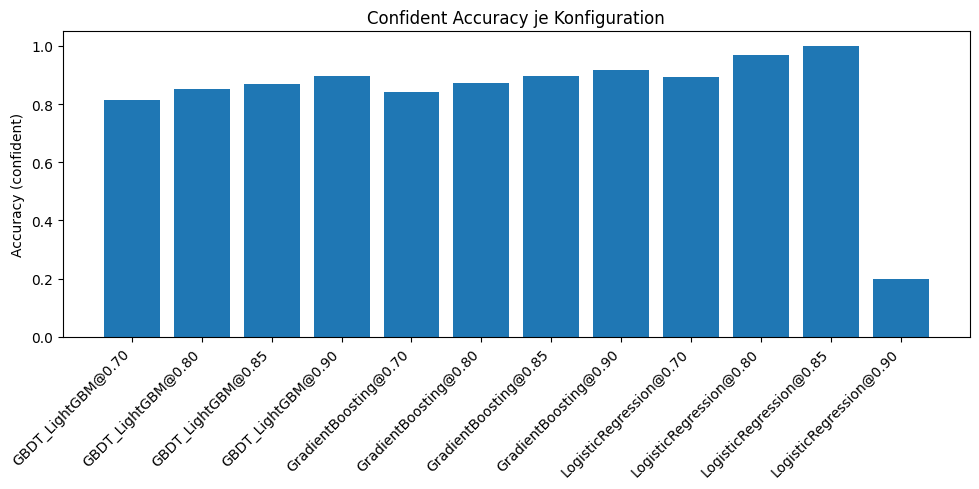

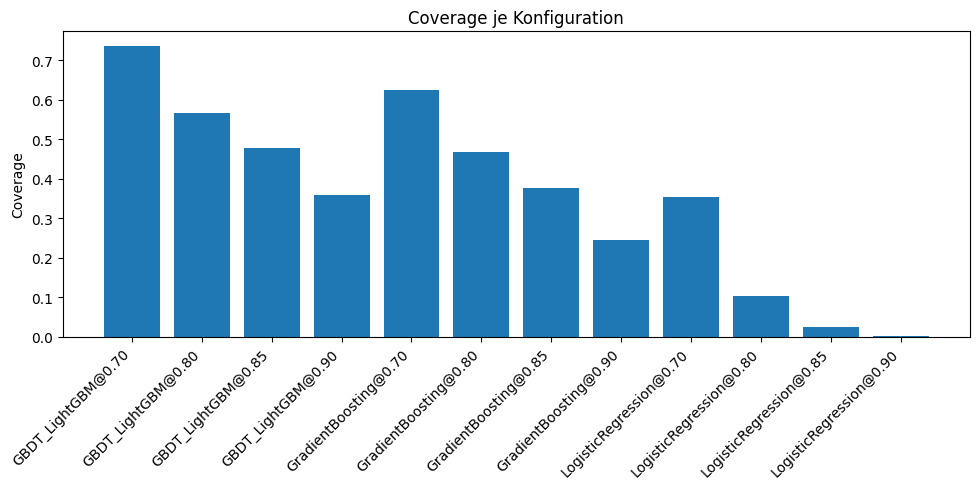

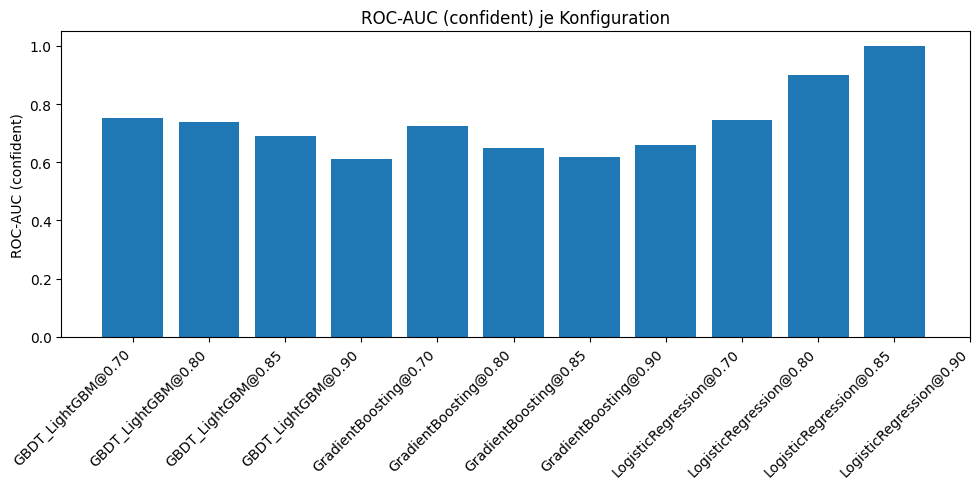

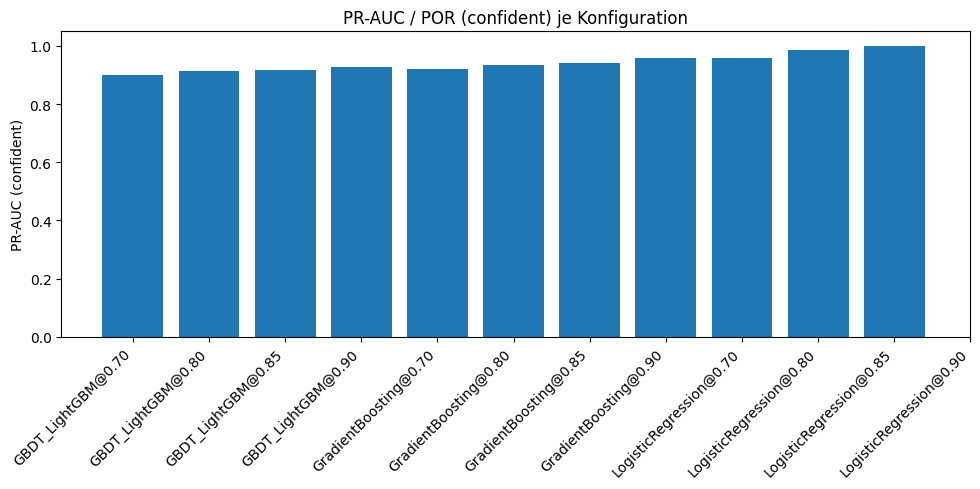

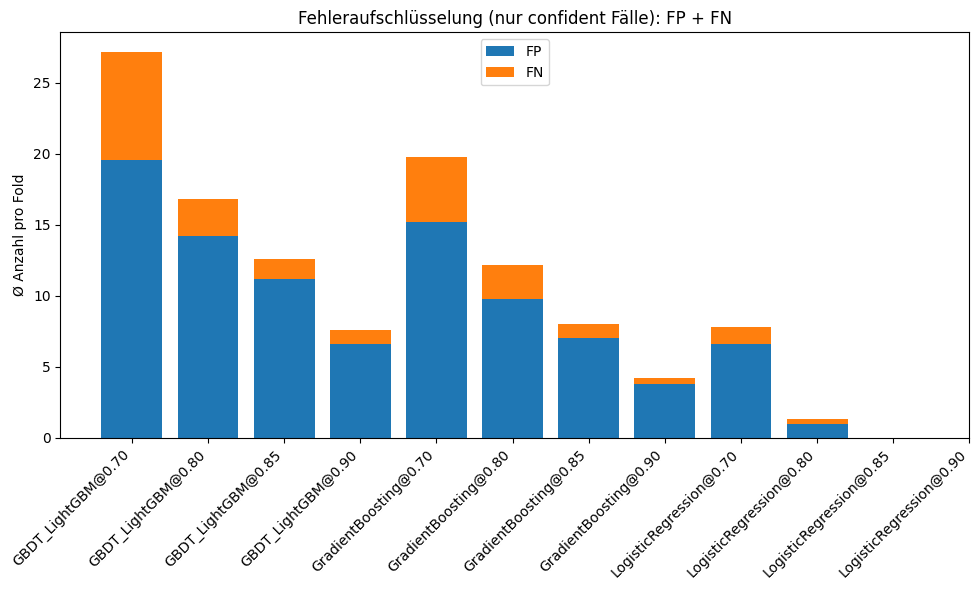

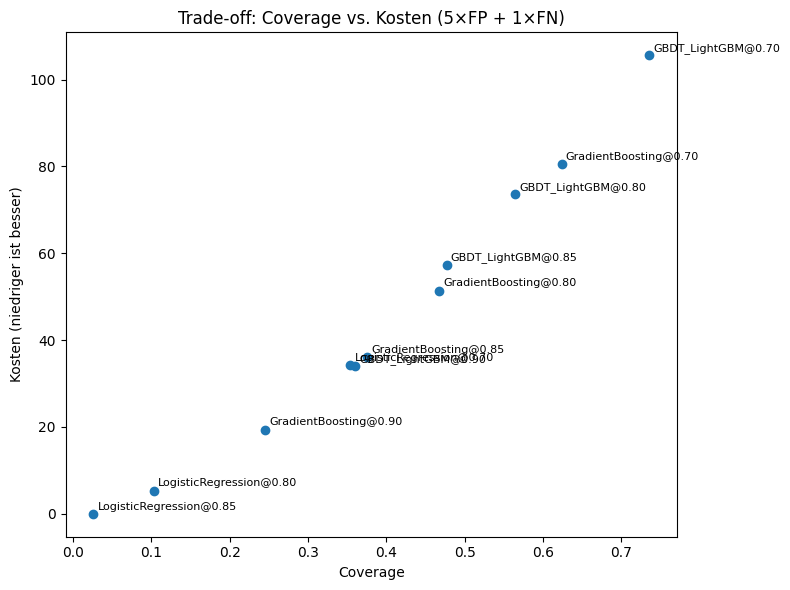

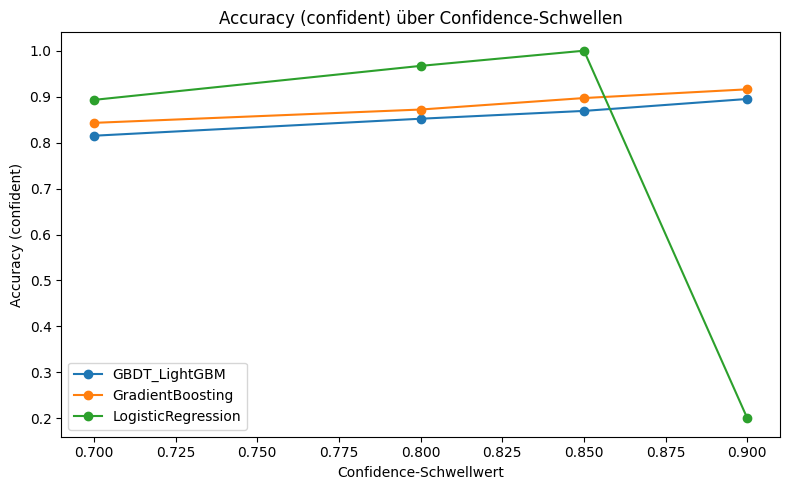

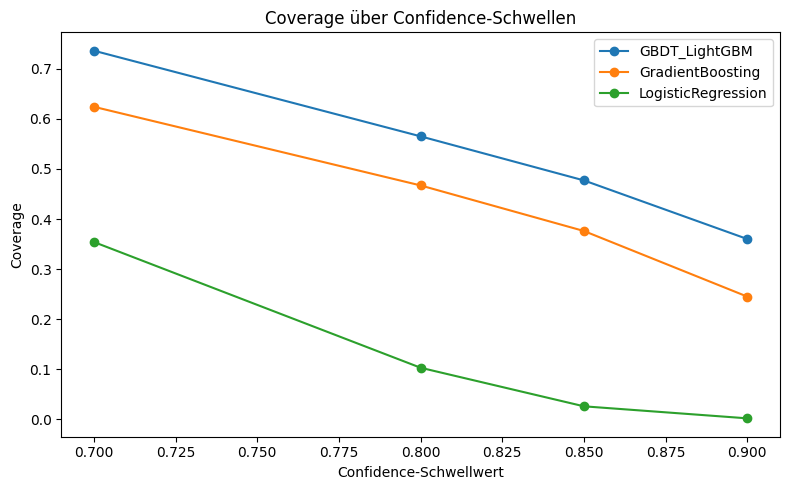

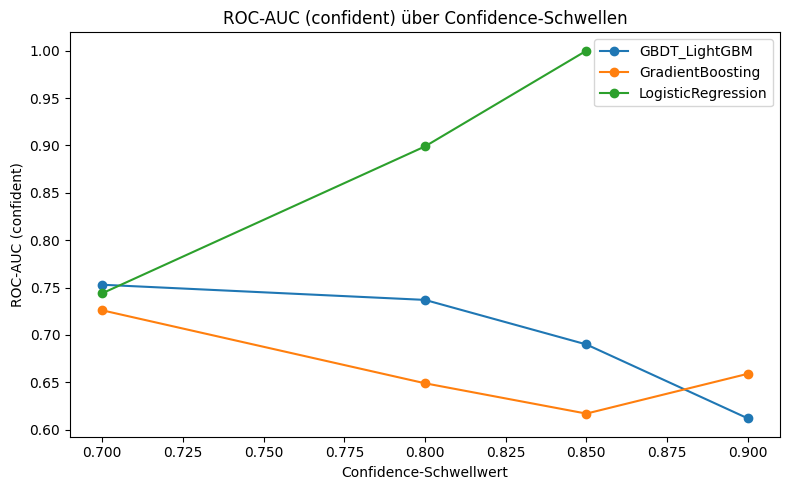

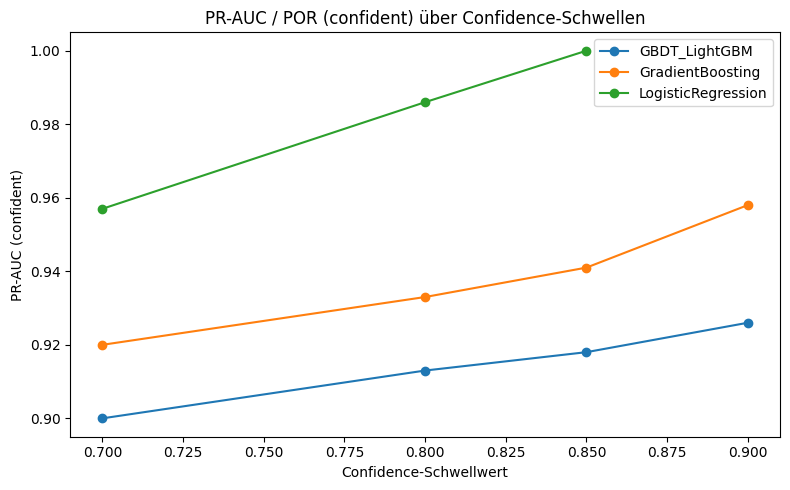

In [67]:
# -------- Plot-Helper für deine "results" DataFrame --------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

def _prepare_summary(results: pd.DataFrame) -> pd.DataFrame:
    # Defensive: falls Spalten fehlen, legen wir sie als NaN an
    cols_needed = [
        'coverage','confident_accuracy','confident_balanced_accuracy',
        'confident_auc','confident_pr_auc','confident_ks','confident_gini',
        'overall_auc','overall_pr_auc','overall_ks',
        'confident_cost_5xFP_1xFN','confident_FP','confident_FN',
        'confidence_threshold'
    ]
    for c in cols_needed:
        if c not in results.columns:
            results[c] = np.nan

    summary = (
        results
        .groupby(['model','confidence_threshold'], as_index=False)
        .agg({
            'coverage':'mean',
            'confident_accuracy':'mean',
            'confident_balanced_accuracy':'mean',
            'confident_auc':'mean',
            'confident_pr_auc':'mean',
            'confident_ks':'mean',
            'confident_gini':'mean',
            'overall_auc':'mean',
            'overall_pr_auc':'mean',
            'overall_ks':'mean',
            'confident_cost_5xFP_1xFN':'mean',
            'confident_FP':'mean',
            'confident_FN':'mean',
        })
        .round(3)
    )
    # Label für die x-Achse
    summary['config'] = summary.apply(
        lambda r: f"{r['model']}@{float(r['confidence_threshold']):.2f}", axis=1
    )
    # Konsistente Sortierung: erst Modell, dann Schwelle
    summary = summary.sort_values(['model','confidence_threshold']).reset_index(drop=True)
    return summary

def _bar_plot(summary: pd.DataFrame, metric: str, title: str, ylabel: str, rotate=45):
    fig = plt.figure(figsize=(10,5))
    x = np.arange(len(summary))
    y = summary[metric].values
    plt.bar(x, y)
    plt.xticks(x, summary['config'].values, rotation=rotate, ha='right')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def _stacked_fp_fn(summary: pd.DataFrame):
    fig = plt.figure(figsize=(10,6))
    x = np.arange(len(summary))
    fp = summary['confident_FP'].values
    fn = summary['confident_FN'].values
    plt.bar(x, fp, label='FP')
    plt.bar(x, fn, bottom=fp, label='FN')
    plt.xticks(x, summary['config'].values, rotation=45, ha='right')
    plt.title('Fehleraufschlüsselung (nur confident Fälle): FP + FN')
    plt.ylabel('Ø Anzahl pro Fold')
    plt.legend()
    plt.tight_layout()
    plt.show()

def _scatter_coverage_cost(summary: pd.DataFrame):
    fig = plt.figure(figsize=(8,6))
    x = summary['coverage'].values
    y = summary['confident_cost_5xFP_1xFN'].values
    plt.scatter(x, y)
    # Annotation mit kurzem Label
    for xi, yi, label in zip(x, y, summary['config'].values):
        plt.annotate(label, (xi, yi), xytext=(3,3), textcoords='offset points', fontsize=8)
    plt.title('Trade-off: Coverage vs. Kosten (5×FP + 1×FN)')
    plt.xlabel('Coverage')
    plt.ylabel('Kosten (niedriger ist besser)')
    plt.tight_layout()
    plt.show()

def _line_by_threshold(summary: pd.DataFrame, metric: str, title: str, ylabel: str):
    """
    Eine Linie je Modell über den Schwellen.
    Hinweis: Wir setzen keine Farben explizit – matplotlib wählt automatisch.
    """
    fig = plt.figure(figsize=(8,5))
    for model, sub in summary.groupby('model'):
        sub = sub.sort_values('confidence_threshold')
        plt.plot(sub['confidence_threshold'].values, sub[metric].values, marker='o', label=model)
    plt.title(title)
    plt.xlabel('Confidence-Schwellwert')
    plt.ylabel(ylabel)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=False, prune=None))
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all(results: pd.DataFrame):
    """
    Erzeugt mehrere Standardplots aus deiner 'results' DF:
      1) Confident Accuracy (Balken)
      2) Coverage (Balken)
      3) ROC-AUC (confident) (Balken)
      4) PR-AUC (confident) (Balken)
      5) Fehler-Stack: FP+FN (Balken, stacked)
      6) Trade-off: Coverage vs. Kosten (Scatter)
      7) Linien über Schwellen: Accuracy, Coverage, ROC-AUC(conf), PR-AUC(conf)
    """
    summary = _prepare_summary(results)

    # 1) Accuracy (confident)
    _bar_plot(summary, 'confident_accuracy',
              'Confident Accuracy je Konfiguration',
              'Accuracy (confident)')

    # 2) Coverage
    _bar_plot(summary, 'coverage',
              'Coverage je Konfiguration',
              'Coverage')

    # 3) ROC-AUC (confident)
    _bar_plot(summary, 'confident_auc',
              'ROC-AUC (confident) je Konfiguration',
              'ROC-AUC (confident)')

    # 4) PR-AUC (confident)
    _bar_plot(summary, 'confident_pr_auc',
              'PR-AUC / POR (confident) je Konfiguration',
              'PR-AUC (confident)')

    # 5) Fehler-Stack FP/FN
    _stacked_fp_fn(summary)

    # 6) Coverage vs. Kosten
    _scatter_coverage_cost(summary)

    # 7) Linienplots über die Schwellen (pro Modell)
    _line_by_threshold(summary, 'confident_accuracy',
                       'Accuracy (confident) über Confidence-Schwellen',
                       'Accuracy (confident)')
    _line_by_threshold(summary, 'coverage',
                       'Coverage über Confidence-Schwellen',
                       'Coverage')
    _line_by_threshold(summary, 'confident_auc',
                       'ROC-AUC (confident) über Confidence-Schwellen',
                       'ROC-AUC (confident)')
    _line_by_threshold(summary, 'confident_pr_auc',
                       'PR-AUC / POR (confident) über Confidence-Schwellen',
                       'PR-AUC (confident)')

# ------------------------------------------------------------
# Ende Plot-Helper
# ------------------------------------------------------------
plot_all(results)


### Entscheidungsnotiz: Wahl des besten Modells

#### Ziele
- **Accuracy**: hoch  
- **False Positives (FP)**: so wenige wie möglich  
- **Trennschärfe zwischen Klassen**: hoch (ROC-AUC / PR-AUC / KS)  
- **Coverage**: akzeptabel (≈ ≥ 0.30), damit genügend Fälle automatisiert werden

---

#### Datengrundlage (aus dem Lauf)
Vergleich nur der Konfigurationen mit **Coverage ≥ ~0.35**:

| Konfiguration                  | Coverage | Accuracy (conf.) | FP / FN (Ø/Fold) | Kosten 5×FP+1×FN | ROC-AUC (conf.) | PR-AUC (conf.) | KS (conf.) |
|--------------------------------|:-------:|:----------------:|:----------------:|:----------------:|:---------------:|:---------------:|:----------:|
| **LogisticRegression @ 0.70**  | **0.354** | 0.893 | 6.6 / 1.2 | 34.2 | **0.744** | **0.957** | **0.471** |
| **GBDT-LightGBM @ 0.90**       | 0.360 | 0.895 | 6.6 / 1.0 | **34.0** | 0.612 | 0.926 | 0.306 |
| **GradientBoosting @ 0.85**    | 0.376 | **0.897** | 7.0 / 1.0 | 36.0 | 0.617 | 0.941 | 0.369 |

> *„conf.“ = Metriken auf dem automatisierten (hoch-sicheren) **confident**-Subset.*

---

#### Entscheidung: **LogisticRegression @ 0.70**

**Warum diese Wahl?**

- **Beste Trennschärfe:** höchste **ROC-AUC (0.744)**, **PR-AUC (0.957)** und **KS (0.471)** unter den Kandidaten mit akzeptabler Coverage → starkes Ranking/Signal.
- **Sehr gute Accuracy:** 0.893 – praktisch auf Augenhöhe mit den Boosting-Varianten (0.895/0.897).
- **Niedriges Risiko:** **FP** und **Kosten** (34.2) auf dem Niveau des besten Kosten-Setups.
- **Coverage akzeptabel:** 0.354 → ~35 % der Fälle können automatisiert werden.

**Kurz:** Höchste Trennschärfe bei sehr guter Accuracy und niedrigen FP – ohne Coverage einzubüßen.

---

#### Sinnvolle Alternativen (je nach Priorität)

1. **FP/Kosten minimal priorisieren → GBDT-LightGBM @ 0.90**  
   - **Niedrigste Kosten** (34.0), leicht weniger FN.  
   - **Aber:** deutlich schwächere Trennschärfe (ROC-AUC/KS) als LR@0.70.

2. **Etwas mehr Coverage bei solider Qualität → GradientBoosting @ 0.85**  
   - **Höchste Coverage** (0.376), beste Accuracy (0.897).  
   - **Aber:** spürbar geringere Trennschärfe als LR@0.70; Kosten etwas höher.

3. **FP extrem minimieren (Coverage < 0.30 akzeptiert) → GradientBoosting @ 0.90**  
   - Sehr wenige FP und niedrigste Kosten.  
   - **Aber:** Coverage nur 0.245 → unter der Akzeptanzgrenze.

---

#### Empfehlung & nächste Schritte
- **Empfohlenes Produktions-Setup:** **LogisticRegression @ 0.70**.  
- **Finale Validierung:** Bestes Modell mit per CV gewählten Hyperparametern auf dem **gesamten Trainingsset** neu fitten und **einmalig** auf einem **unberührten Holdout-Testset** evaluieren.  
- **Monitoring/Transparenz:**  
  - **Precision/Recall** (confident + overall) zusätzlich ausweisen, um „keine FP“ eng zu überwachen.  
  - Optional zweite Betriebsvariante **GBDT @ 0.90** als „Low-FP-Policy“ für besonders risikoreiche Segmente.

> **Bottom line:** Bei deinem Zielmix aus **hoher Accuracy**, **wenigen FP**, **starker Trennschärfe** und **akzeptabler Coverage** ist **LogisticRegression @ 0.70** der beste Gesamt-Pick.


_____________________________________
_____________________________________

## Logistic-Banking-Workflow (LR@0.70) — Modelle, Hyperparameter, Regularisierung & Evaluation

### 1) Modell(e)
- **Hauptmodell:** `LogisticRegression` in Pipeline mit `StandardScaler`
  - **Solver:** `liblinear` (unterstützt L1 **und** L2)
  - **Aufgabe:** Binärklassifikation `y∈{0=bad,1=good}`
- **Konfiguration:** LRBanksConfig(confidence_threshold=0.70, decision_threshold=0.50, cv_folds=5, random_state=42)

---

### 2) Hyperparameter-Suche (GridSearchCV, scoring='roc_auc')
- **Grid (inneres CV, k=5, stratifiziert):**
  - `clf__C ∈ {0.01, 0.1, 1, 10, 100}`  → Regularisierungsstärke (klein = stärker)
  - `clf__penalty ∈ {l1, l2}`            → L1 (Sparsity) oder L2 (Shrinkage)
  - `clf__solver='liblinear'`            → stabil für kleine/mittlere Datasets, unterstützt L1/L2
- **Auswahlkriterium:** bester **ROC-AUC**-Mittelwert im inneren CV

---

### 3) Regularisierung & Verlust
- **Regressionsverlust:** binärer Log-Loss (implizit bei logistischer Regression)
- **Regularisierung:** **L1** *oder* **L2** (aus Grid)
  - **L1:** Merkmals-Selektion durch Nullen von Koeffizienten
  - **L2:** Stabilisierung bei Korrelation/Varianz (Shrinkage)
- **Skalierung:** `StandardScaler` (zentriert/standardisiert Features → stabilere Koeffizienten)

---

### 4) Confidence-Gating & Decision-Threshold
- **Confidence-Filter:** automatisiere nur Fälle mit **hoher Sicherheit**
  - Regel: `p ≥ 0.70` (good) **oder** `p ≤ 0.30` (bad) → **confident**  
  - Sonst: **Abstain** (`-1`) → manuelle Prüfung
- **Decision-Threshold (Klassengrenze):** initial `0.50`, **optimiert** auf dem **Train** via **OOF-CV**
  - **Ziel:** Minimiere **Kosten** `5×FP + 1×FN` **nur auf confident-Zone**
  - **Sweep:** `t ∈ [0.50, 0.80]` (31 Punkte); Tiebreaker: geringere FP → höhere Acc → höhere Coverage

---

### 5) Evaluation (Metriken)
**Overall (alle Fälle, ohne Abstain):**
- **ROC-AUC**, **PR-AUC (Average Precision)**, **KS**, **Precision**, **Recall**, **Gini = 2·AUC−1**

**Confident-Subset (nur automatisierte Fälle):**
- **Accuracy**, **Balanced Accuracy**, **Precision**, **Recall**
- **ROC-AUC**, **PR-AUC**, **KS**, **Gini**
- **Coverage** (Anteil automatisierter Fälle)
- **Kostenmaß:** `5×FP + 1×FN`
- **Confusion-Matrix** (nur confident-Fälle)

**Validierungsprotokoll:**
- **Train/Test-Split** mit **stratifiziertem** Holdout (`test_size` adaptiv per `choose_test_size`, i. d. R. 10–20 %)
- **Inneres CV (GridSearch)** auf **Train**
- **OOF-Optimierung** des Decision-Thresholds auf **Train**
- **Optional:** **Cross-Validation auf Train** (äußeres CV für Erwartungswerte)
- **Final:** **Holdout-Test** (unberührter Test) + Plots/Markdown-Report

---

### 6) Plots & Explainability
- **ROC- & PR-Kurven** (Markierung des Decision-Thresholds)
- **Wahrscheinlichkeitsverteilungen** (Good/Bad, Conf-/Dec-Linien)
- **Accuracy-vs-Coverage** (Confidence-Sweep)
- **Confident Confusion Matrix**
- **Top-Koeffizienten** (standardisierter Raum) → **Erklärbarkeit** (Richtung/Einfluss)

---

### 7) Gründe für Design-Entscheidungen (kurz)
- **LR + Scaler:** interpretierbar, stabil, auditierbar (DSGVO/Bankaufsicht)
- **AUC-basiertes Tuning:** rangbasierte Trennschärfe, robust gg. Schwellen
- **Confidence-Gating:** reduziert Fehlerrisiko bei Auto-Entscheidungen; klärt **Coverage↔Qualität**
- **Kostenoptimierung (5×FP + 1×FN):** banknaher Proxy (FP teurer als FN; anpassbar)
- **OOF-Thresholding:** vermeidet Test-Leak, realistischere Schwellenwahl
- **Balanced Accuracy & KS/PR-AUC:** geeignet bei Imbalance & für Banking-Scorecards

---

### 8) Kompakte Tabelle

| Baustein | Wahl | Zweck/Grund |
|---|---|---|
| Modell | LogisticRegression | Binärer Log-Loss, interpretierbar |
| Solver | liblinear | L1/L2 möglich, stabil |
| Regularizer | L1/L2 (Grid) | Sparsity vs. Shrinkage |
| C | {0.01,…,100} | Reg.-Stärke (klein=stark) |
| Skalierung | StandardScaler | stabile Koeffizienten |
| Model-Selection | GridSearchCV(k=5, AUC) | beste Trennschärfe |
| Confidence | thr=0.70 | nur sichere Auto-Entscheide |
| Decision t | OOF-optimiert (0.50–0.80) | min Kosten 5×FP+1×FN |
| Overall-Metriken | AUC, PR-AUC, KS, Prec/Rec | komplette Datenlage |
| Confident-Metriken | Acc, BalAcc, AUC/PR, KS, Gini, Kosten | Qualität der Auto-Fälle |
| CV (Train) | StratifiedKFold(k=5) | erwartete Varianz/Leistung |
| Holdout-Test | stratifizierter Split | finale, unbeeinflusste Messung |

---

### 9) Output (aus dem Skript)
- Bestes LR-Modell + **Best Params** (aus Grid)
- **OOF-optimaler Decision-Threshold**
- **Holdout-Test**-Metriken (overall & confident)
- **CV-Summary** auf Train (optional)
- **Diagnose-Plots** & **Markdown-Report** mit Top-Koeffizienten



Prepared data: n=1000, d=17, good%=70.00%
Split: train=900, test=100 (test_size=10%)
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV ROC-AUC: 0.737

Optimizing decision threshold on TRAIN via OOF-CV (cost=5×FP + 1×FN)...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV ROC-AUC: 0.740
  Collected OOF probabilities for fold 1
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV ROC-AUC: 0.737
  Collected OOF probabilities for fold 2
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Params: {'clf__C': 0.01, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Best CV ROC-AUC: 0.730
  Collected OOF probabilities for fold 3
Fitting 5 folds for each of 10 candidates, totalling 50 fit

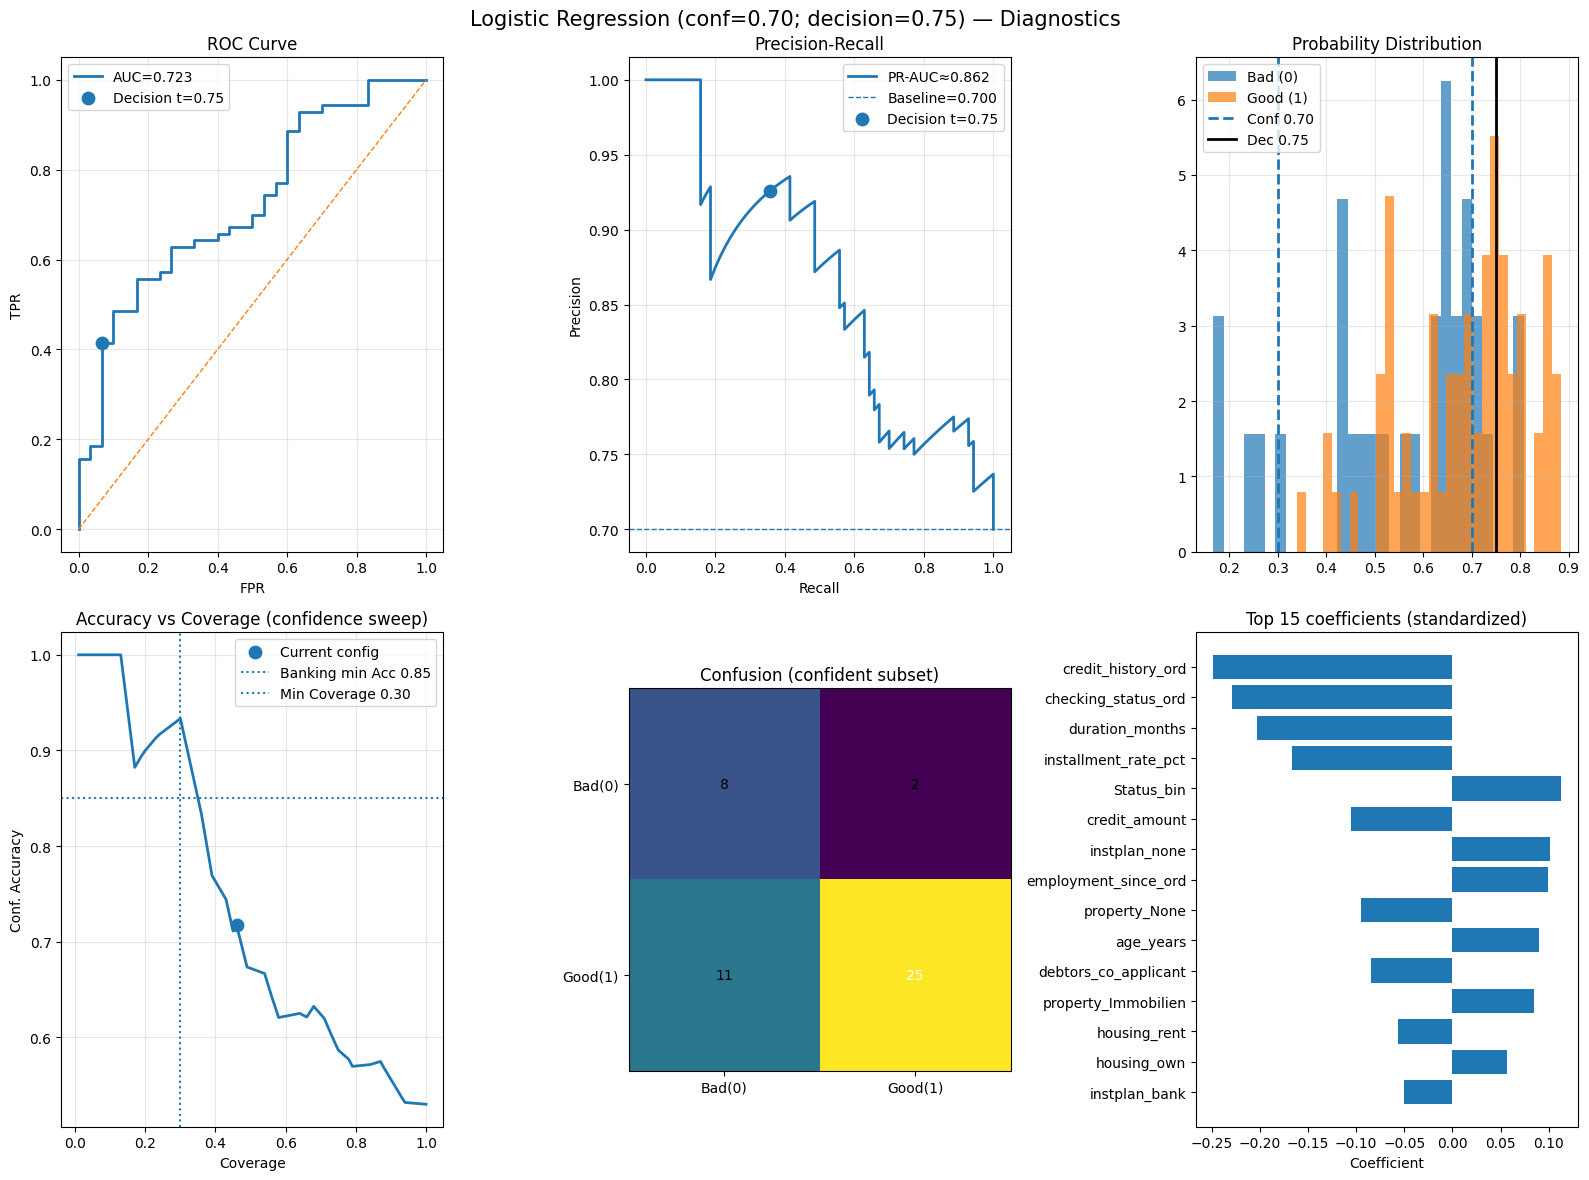


Markdown für Doku/Review:
 
# Entscheidungsnotiz – Logistic Regression @ 70% Confidence, Decision @ 0.75

**Warum LR @ 0.70 / Decision 0.75?**  
- **Trennschärfe** (conf): ROC-AUC = 0.836, PR-AUC = 0.938, KS = 0.644  
- **Accuracy (conf)**: 0.717 bei **Coverage** 0.460  
- **Risiko**: FP=2, FN=11, **Cost(5×FP+1×FN)**=21.0  
- **Interpretierbarkeit**: Signifikante Koeffizienten (standardisiert) → fachliche Nachvollziehbarkeit.

**Top-Koeffizienten (absolut) – Richtung zeigt Einfluss auf „good“ (1):**  
             feature      coef  abs_coef
  credit_history_ord -0.248166  0.248166
 checking_status_ord -0.228338  0.228338
     duration_months -0.202931  0.202931
installment_rate_pct -0.166372  0.166372
          Status_bin  0.112315  0.112315
       credit_amount -0.104917  0.104917
       instplan_none  0.101507  0.101507
employment_since_ord  0.099445  0.099445
       property_None -0.095119  0.095119
           age_years  0.089959  0.089959

Dieses Skript definiert LR@0.70-Workflow

In [70]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple, Dict, Any, Optional

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, roc_auc_score, confusion_matrix,
    average_precision_score, roc_curve, precision_recall_curve, precision_score, recall_score
)

import matplotlib.pyplot as plt


# =========================
# Utils
# =========================

def ks_statistic(y_true: np.ndarray, y_score: np.ndarray) -> float:
    if len(np.unique(y_true)) < 2:
        return np.nan
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return float(np.max(tpr - fpr))

def gini_from_auc(auc: Optional[float]) -> float:
    return (2*auc - 1) if (auc is not None and not np.isnan(auc)) else np.nan

def choose_test_size(y: pd.Series, min_pos=30, min_neg=30, default=0.10, max_test=0.20) -> float:
    N = len(y)
    p = y.mean() if N > 0 else 0.5
    for t in [default, 0.12, 0.15, 0.18, max_test]:
        if (t*N*p >= min_pos) and (t*N*(1-p) >= min_neg):
            return t
    return max_test


# =========================
# Core class (LR @ 0.70)
# =========================

@dataclass
class LRBanksConfig:
    confidence_threshold: float = 0.70       # Gate: nur sehr sichere Fälle werden automatisiert
    decision_threshold: float = 0.50         # Klassifikationsschwelle für "good" vs "bad"
    cv_folds: int = 5
    random_state: int = 42

class LogisticBankingModel:
    def __init__(self, config: LRBanksConfig = LRBanksConfig()):
        self.config = config
        self.model: Optional[Pipeline] = None
        self.best_params: Optional[Dict[str, Any]] = None
        self.is_trained: bool = False
        self.feature_names_: Optional[list] = None

    def _make_pipeline(self) -> Pipeline:
        return Pipeline([
            ('scaler', StandardScaler()),
            ('clf', LogisticRegression(max_iter=1000, random_state=self.config.random_state))
        ])

    def fit_with_cv(self, X: pd.DataFrame, y: pd.Series) -> "LogisticBankingModel":
        self.feature_names_ = list(X.columns)
        pipe = self._make_pipeline()
        param_grid = {
            'clf__C': [0.01, 0.1, 1, 10, 100],
            'clf__penalty': ['l1', 'l2'],
            'clf__solver': ['liblinear']  # passend für l1/l2
        }
        gs = GridSearchCV(
            pipe, param_grid,
            cv=StratifiedKFold(n_splits=self.config.cv_folds, shuffle=True, random_state=self.config.random_state),
            scoring='roc_auc', n_jobs=-1, verbose=1
        )
        gs.fit(X, y)
        self.model = gs.best_estimator_
        self.best_params = gs.best_params_
        self.is_trained = True
        print("\nBest Params:", self.best_params)
        print(f"Best CV ROC-AUC: {gs.best_score_:.3f}")
        return self

    # ---- helper: predictions & gating ----
    def _confidence_mask(self, proba: np.ndarray) -> np.ndarray:
        thr = self.config.confidence_threshold
        return (proba >= thr) | (proba <= (1 - thr))

    # ---- prediction with abstention (confidence) ----
    def predict_with_confidence(self, X: pd.DataFrame) -> Dict[str, Any]:
        if not self.is_trained:
            raise ValueError("Model must be trained first.")
        proba = self.model.predict_proba(X)[:, 1]
        mask = self._confidence_mask(proba)
        preds = np.full(len(X), -1)  # -1 = human review
        # >>> Klassifikationsschwelle nutzt decision_threshold <<<
        preds[mask] = (proba[mask] >= self.config.decision_threshold).astype(int)
        return {
            'probabilities': proba,
            'predictions': preds,
            'confident_mask': mask,
            'coverage': float(np.mean(mask))
        }

    # ---- evaluation (confident subset + overall) ----
    def evaluate(self, X: pd.DataFrame, y: pd.Series) -> Dict[str, Any]:
        y_arr = y.values if hasattr(y, 'values') else y
        res = self.predict_with_confidence(X)
        proba, preds, mask = res['probabilities'], res['predictions'], res['confident_mask']
        coverage = res['coverage']

        # overall (ohne Abstain) – Klassifikation mit decision_threshold
        overall_preds = (proba >= self.config.decision_threshold).astype(int)
        if len(np.unique(y_arr)) > 1:
            overall_auc = roc_auc_score(y_arr, proba)
            overall_pr = average_precision_score(y_arr, proba)
        else:
            overall_auc = overall_pr = np.nan
        overall_ks = ks_statistic(y_arr, proba)
        overall_precision = precision_score(y_arr, overall_preds, zero_division=0)
        overall_recall = recall_score(y_arr, overall_preds, zero_division=0)

        # confident subset
        if mask.sum() == 0:
            cm = np.array([[0, 0], [0, 0]])
            conf_acc = conf_bacc = conf_auc = conf_pr = conf_ks = conf_prec = conf_rec = np.nan
            fp = fn = cost = np.nan
            conf_samples = 0
        else:
            y_conf = y_arr[mask]
            p_conf = proba[mask]
            yhat_conf = (p_conf >= self.config.decision_threshold).astype(int)

            conf_acc = accuracy_score(y_conf, yhat_conf)
            conf_bacc = balanced_accuracy_score(y_conf, yhat_conf)
            conf_prec = precision_score(y_conf, yhat_conf, zero_division=0)
            conf_rec = recall_score(y_conf, yhat_conf, zero_division=0)
            if len(np.unique(y_conf)) > 1:
                conf_auc = roc_auc_score(y_conf, p_conf)
                conf_pr  = average_precision_score(y_conf, p_conf)
                conf_ks  = ks_statistic(y_conf, p_conf)
            else:
                conf_auc = conf_pr = conf_ks = np.nan

            cm = confusion_matrix(y_conf, yhat_conf, labels=[0, 1])
            tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (np.nan, np.nan, np.nan, np.nan)
            cost = 5*fp + 1*fn
            conf_samples = int(mask.sum())

        return {
            'coverage': coverage,
            'confident_samples': conf_samples,
            'total_samples': len(y_arr),

            'confident_accuracy': conf_acc,
            'confident_balanced_accuracy': conf_bacc,
            'confident_precision': conf_prec,
            'confident_recall': conf_rec,
            'confident_auc': conf_auc,
            'confident_pr_auc': conf_pr,
            'confident_ks': conf_ks,
            'confident_gini': gini_from_auc(conf_auc),
            'confusion_matrix': cm,
            'false_positives': fp,
            'false_negatives': fn,
            'cost_5xFP_1xFN': cost,

            'overall_auc': overall_auc,
            'overall_pr_auc': overall_pr,
            'overall_ks': overall_ks,
            'overall_precision': overall_precision,
            'overall_recall': overall_recall
        }

    # ---- Threshold-Kosten auf Training via OOF-CV optimieren (kein Test-Leak) ----
    @staticmethod
    def _conf_cost_at_t(y_true: np.ndarray, proba: np.ndarray, conf_thr: float, dec_thr: float):
        mask = (proba >= conf_thr) | (proba <= (1 - conf_thr))
        if mask.sum() == 0:
            return dict(cost=np.inf, FP=np.nan, FN=np.nan, acc=np.nan, prec=np.nan, rec=np.nan,
                        coverage=0.0, samples=0)
        y_c = y_true[mask]
        yhat = (proba[mask] >= dec_thr).astype(int)
        cm = confusion_matrix(y_c, yhat, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        cost = 5*fp + 1*fn
        return dict(
            cost=float(cost),
            FP=int(fp), FN=int(fn),
            acc=float(accuracy_score(y_c, yhat)),
            prec=float(precision_score(y_c, yhat, zero_division=0)),
            rec=float(recall_score(y_c, yhat, zero_division=0)),
            coverage=float(np.mean(mask)),
            samples=int(mask.sum())
        )

    def optimize_decision_threshold_on_training(
        self, X: pd.DataFrame, y: pd.Series,
        grid: np.ndarray = np.linspace(0.50, 0.80, 31)
    ) -> Dict[str, Any]:
        """
        Verwendet Stratified K-Fold, sammelt OOF-Probas und minimiert die Kosten (5×FP + 1×FN)
        nur in der confident-Zone. Setzt anschließend self.config.decision_threshold.
        """
        print("\nOptimizing decision threshold on TRAIN via OOF-CV (cost=5×FP + 1×FN)...")
        skf = StratifiedKFold(n_splits=self.config.cv_folds, shuffle=True, random_state=self.config.random_state)
        oof_idx = np.zeros(len(y), dtype=bool)
        oof_proba = np.zeros(len(y), dtype=float)

        for fold, (tri, tei) in enumerate(skf.split(X, y), 1):
            Xtr, Xval = X.iloc[tri], X.iloc[tei]
            ytr = y.iloc[tri]
            tmp = LogisticBankingModel(self.config)
            tmp.fit_with_cv(Xtr, ytr)  # inner tuning
            oof_proba[tei] = tmp.model.predict_proba(Xval)[:, 1]
            oof_idx[tei] = True
            print(f"  Collected OOF probabilities for fold {fold}")

        assert oof_idx.all(), "OOF probabilities missing for some samples."

        # sweep thresholds
        records = []
        y_true = y.values
        for t in grid:
            m = self._conf_cost_at_t(y_true, oof_proba, self.config.confidence_threshold, t)
            m['threshold'] = float(t)
            records.append(m)
        curve = pd.DataFrame(records)

        # choose best threshold: min cost → tie-break by lower FP → higher acc → higher coverage
        curve_sorted = curve.sort_values(['cost','FP','acc','coverage'], ascending=[True, True, False, False])
        best_row = curve_sorted.iloc[0]
        best_t = float(best_row['threshold'])
        self.config.decision_threshold = best_t

        print(f"Best decision threshold (OOF): {best_t:.3f} | cost={best_row['cost']:.1f} "
              f"| FP={int(best_row['FP'])} | FN={int(best_row['FN'])} "
              f"| acc={best_row['acc']:.3f} | cov={best_row['coverage']:.3f}")
        return {'best_threshold': best_t, 'curve': curve, 'best_row': best_row.to_dict()}

    # ---- CV on training only (for expectation) ----
    def cross_validate_training(self, X: pd.DataFrame, y: pd.Series) -> pd.DataFrame:
        print("\nCross-Validation on TRAIN (expectations):")
        skf = StratifiedKFold(n_splits=self.config.cv_folds, shuffle=True, random_state=self.config.random_state)
        rows = []
        for k, (tri, tei) in enumerate(skf.split(X, y), 1):
            Xtr, Xte = X.iloc[tri], X.iloc[tei]
            ytr, yte = y.iloc[tri], y.iloc[tei]
            tmp = LogisticBankingModel(self.config)
            tmp.fit_with_cv(Xtr, ytr)  # inner GS
            m = tmp.evaluate(Xte, yte)
            m['fold'] = k
            rows.append(m)
            print(f"  Fold {k}: Acc(conf)={m['confident_accuracy']:.3f} | Cov={m['coverage']:.3f}")
        return pd.DataFrame(rows)

    # ---- Explainability: top coefficients (standardized space) ----
    def top_coefficients(self, k: int = 15) -> pd.DataFrame:
        if not self.is_trained:
            raise ValueError("Model must be trained.")
        clf = self.model.named_steps['clf']
        if not hasattr(clf, 'coef_'):
            raise ValueError("No coefficients available.")
        coefs = clf.coef_[0]
        feats = self.feature_names_ or [f"f{i}" for i in range(len(coefs))]
        df = pd.DataFrame({'feature': feats, 'coef': coefs, 'abs_coef': np.abs(coefs)})
        return df.sort_values('abs_coef', ascending=False).head(k).reset_index(drop=True)

    # ---- Plots (test set) ----
    def plot_diagnostics(self, X: pd.DataFrame, y: pd.Series, topk: int = 15, figsize=(16, 12)):
        if not self.is_trained:
            raise ValueError("Model must be trained.")
        y_arr = y.values if hasattr(y, 'values') else y
        pred = self.predict_with_confidence(X)
        proba, mask = pred['probabilities'], pred['confident_mask']
        conf_thr = self.config.confidence_threshold
        dec_thr = self.config.decision_threshold

        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle(f'Logistic Regression (conf={conf_thr:.2f}; decision={dec_thr:.2f}) — Diagnostics', fontsize=15)

        # ROC
        fpr, tpr, roc_thresholds = roc_curve(y_arr, proba)
        auc_roc = np.trapz(tpr, fpr)
        axes[0,0].plot(fpr, tpr, lw=2, label=f'AUC={auc_roc:.3f}')
        axes[0,0].plot([0,1], [0,1], lw=1, linestyle='--')
        # mark decision threshold point on ROC (nearest)
        idx = np.argmin(np.abs(roc_thresholds - dec_thr))
        axes[0,0].scatter(fpr[idx], tpr[idx], s=80, label=f'Decision t={dec_thr:.2f}')
        axes[0,0].set_title('ROC Curve'); axes[0,0].set_xlabel('FPR'); axes[0,0].set_ylabel('TPR')
        axes[0,0].legend(); axes[0,0].grid(alpha=0.3)

        # PR
        precision, recall, pr_thresholds = precision_recall_curve(y_arr, proba)
        # pr_thresholds length = n-1; sichere Indexwahl:
        pr_idx = np.argmin(np.abs(pr_thresholds - dec_thr)) if len(pr_thresholds) > 0 else None
        pr_auc = np.trapz(precision[::-1], recall[::-1])  # approx area
        axes[0,1].plot(recall, precision, lw=2, label=f'PR-AUC≈{pr_auc:.3f}')
        baseline = y_arr.mean()
        axes[0,1].axhline(baseline, linestyle='--', lw=1, label=f'Baseline={baseline:.3f}')
        if pr_idx is not None and pr_idx < len(recall):
            axes[0,1].scatter(recall[pr_idx], precision[pr_idx], s=80, label=f'Decision t={dec_thr:.2f}')
        axes[0,1].set_title('Precision-Recall'); axes[0,1].set_xlabel('Recall'); axes[0,1].set_ylabel('Precision')
        axes[0,1].legend(); axes[0,1].grid(alpha=0.3)

        # Probability distributions
        axes[0,2].hist(proba[y_arr==0], bins=30, alpha=0.7, density=True, label='Bad (0)')
        axes[0,2].hist(proba[y_arr==1], bins=30, alpha=0.7, density=True, label='Good (1)')
        axes[0,2].axvline(conf_thr, linestyle='--', lw=2, label=f'Conf {conf_thr:.2f}')
        axes[0,2].axvline(1-conf_thr, linestyle='--', lw=2)
        axes[0,2].axvline(dec_thr, color='k', lw=2, label=f'Dec {dec_thr:.2f}')
        axes[0,2].set_title('Probability Distribution'); axes[0,2].legend(); axes[0,2].grid(alpha=0.3)

        # Accuracy vs Coverage (confidence sweep, decision fixed)
        tgrid = np.arange(0.50, 0.96, 0.01)
        covs, accs = [], []
        for t in tgrid:
            m = (proba >= t) | (proba <= (1-t))
            if m.sum() > 0:
                y_c = y_arr[m]
                accs.append(accuracy_score(y_c, (proba[m] >= dec_thr)))
                covs.append(np.mean(m))
            else:
                accs.append(np.nan); covs.append(0.0)
        axes[1,0].plot(covs, accs, lw=2)
        # mark current
        cur_eval = self.evaluate(X, y)
        axes[1,0].scatter([cur_eval['coverage']], [cur_eval['confident_accuracy']], s=80, label='Current config')
        axes[1,0].axhline(0.85, linestyle=':', label='Banking min Acc 0.85')
        axes[1,0].axvline(0.30, linestyle=':', label='Min Coverage 0.30')
        axes[1,0].set_title('Accuracy vs Coverage (confidence sweep)'); axes[1,0].set_xlabel('Coverage'); axes[1,0].set_ylabel('Conf. Accuracy')
        axes[1,0].legend(); axes[1,0].grid(alpha=0.3)

        # Confident Confusion Matrix
        axes[1,1].set_title('Confusion (confident subset)')
        if mask.sum() > 0:
            y_c = y_arr[mask]; yhat_c = (proba[mask] >= dec_thr).astype(int)
            cm = confusion_matrix(y_c, yhat_c, labels=[0,1])
            im = axes[1,1].imshow(cm, interpolation='nearest')
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    axes[1,1].text(j, i, int(cm[i,j]), ha='center', va='center',
                                   color='white' if cm[i,j] > cm.max()/2 else 'black')
            axes[1,1].set_xticks([0,1]); axes[1,1].set_yticks([0,1])
            axes[1,1].set_xticklabels(['Bad(0)','Good(1)']); axes[1,1].set_yticklabels(['Bad(0)','Good(1)'])
        else:
            axes[1,1].text(0.5, 0.5, 'No confident predictions', ha='center', va='center', transform=axes[1,1].transAxes)

        # Top coefficients (explainability)
        top = self.top_coefficients(k=topk)
        axes[1,2].barh(top['feature'][::-1], top['coef'][::-1])
        axes[1,2].set_title(f'Top {topk} coefficients (standardized)')
        axes[1,2].set_xlabel('Coefficient')
        plt.tight_layout()
        plt.show()

    # Optional: Plot Kostenkurve (decision threshold)
    def plot_decision_threshold_cost_curve(self, y_true: np.ndarray, proba: np.ndarray,
                                           grid: np.ndarray = np.linspace(0.50, 0.80, 31)):
        recs = []
        for t in grid:
            m = self._conf_cost_at_t(y_true, proba, self.config.confidence_threshold, t)
            m['threshold'] = float(t)
            recs.append(m)
        df = pd.DataFrame(recs)
        plt.figure(figsize=(6,4))
        plt.plot(df['threshold'], df['cost'], lw=2, label='Cost (5×FP + 1×FN)')
        plt.axvline(self.config.decision_threshold, linestyle='--', label=f'Chosen t={self.config.decision_threshold:.2f}')
        plt.xlabel('Decision Threshold'); plt.ylabel('Cost'); plt.title('Cost vs Decision Threshold')
        plt.grid(alpha=0.3); plt.legend(); plt.show()
        return df


# =========================
# Workflow (CV on train + holdout test)
# =========================

def prepare_banking_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    if 'target' not in df.columns:
        raise ValueError("DataFrame must contain 'target' column with values 1 (good) and 2 (bad).")
    y = (df['target'] == 1).astype(int)
    X = df.drop(columns=['target']).copy()
    print(f"Prepared data: n={len(X)}, d={X.shape[1]}, good%={y.mean():.2%}")
    return X, y

def train_lr_banking_with_holdout(
    df: pd.DataFrame,
    confidence_threshold: float = 0.70,
    inner_cv_folds: int = 5,
    test_size: Optional[float] = None,
    run_train_cv_summary: bool = True,
    optimize_decision_threshold: bool = True
):
    # Prepare + split
    X, y = prepare_banking_data(df)
    if test_size is None:
        test_size = choose_test_size(y, min_pos=30, min_neg=30, default=0.10, max_test=0.20)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )
    print(f"Split: train={len(X_tr)}, test={len(X_te)} (test_size={test_size:.0%})")

    # Train with CV on TRAIN only
    cfg = LRBanksConfig(confidence_threshold=confidence_threshold, cv_folds=inner_cv_folds)
    model = LogisticBankingModel(cfg).fit_with_cv(X_tr, y_tr)

    # Optional: decision threshold optimization on TRAIN via OOF
    if optimize_decision_threshold:
        opt = model.optimize_decision_threshold_on_training(X_tr, y_tr, grid=np.linspace(0.50, 0.80, 31))
        # (Optional) OOF-Kostenkurve plotten:
        # model.plot_decision_threshold_cost_curve(y_tr.values, ???)  # OOF proba steckt in opt['curve']

    # Optional CV summary (outer CV across train) – zur Erwartung
    cv_df = None
    if run_train_cv_summary:
        cv_df = model.cross_validate_training(X_tr, y_tr)
        print("\nTraining CV (conf subset) summary:")
        print(cv_df[['fold','confident_accuracy','coverage','cost_5xFP_1xFN']].round(3).to_string(index=False))

    # One-shot evaluation on untouched TEST
    print(f"\nUsing decision_threshold={model.config.decision_threshold:.2f}")
    test_metrics = model.evaluate(X_te, y_te)
    print("\n===== HOLDOUT TEST RESULTS =====")
    for k, v in test_metrics.items():
        if isinstance(v, float):
            print(f"{k}: {v:.3f}" if not np.isnan(v) else f"{k}: NA")
        else:
            print(f"{k}: {v}")

    # Plots on TEST
    model.plot_diagnostics(X_te, y_te, topk=15)

    # Decision Markdown (explainability)
    top = model.top_coefficients(k=10)
    md = f"""
# Entscheidungsnotiz – Logistic Regression @ {int(confidence_threshold*100)}% Confidence, Decision @ {model.config.decision_threshold:.2f}

**Warum LR @ 0.70 / Decision {model.config.decision_threshold:.2f}?**  
- **Trennschärfe** (conf): ROC-AUC = {test_metrics['confident_auc']:.3f}, PR-AUC = {test_metrics['confident_pr_auc']:.3f}, KS = {test_metrics['confident_ks']:.3f}  
- **Accuracy (conf)**: {test_metrics['confident_accuracy']:.3f} bei **Coverage** {test_metrics['coverage']:.3f}  
- **Risiko**: FP={test_metrics['false_positives']}, FN={test_metrics['false_negatives']}, **Cost(5×FP+1×FN)**={test_metrics['cost_5xFP_1xFN']:.1f}  
- **Interpretierbarkeit**: Signifikante Koeffizienten (standardisiert) → fachliche Nachvollziehbarkeit.

**Top-Koeffizienten (absolut) – Richtung zeigt Einfluss auf „good“ (1):**  
{top.to_string(index=False)}
"""
    print("\nMarkdown für Doku/Review:\n", md)
    return model, (X_tr, X_te, y_tr, y_te), test_metrics, cv_df


# =========================
# Example main
# =========================
if __name__ == "__main__":
    #  CSV einlesen (spalte 'target' = {1: good, 2: bad})
    df = pd.read_csv("kredit_final.csv")
    model, splits, test_metrics, cv_df = train_lr_banking_with_holdout(
        df,
        confidence_threshold=0.70,
        inner_cv_folds=5,
        test_size=None,
        run_train_cv_summary=True,
        optimize_decision_threshold=True
    )

    print("Dieses Skript definiert LR@0.70-Workflow mit OOF-optimiertem Decision-Threshold, CV (Train) + Holdout-Test + Plots + Erklär-Markdown.")
    print("Nutzen: train_lr_banking_with_holdout(df, confidence_threshold=0.70)")


### Entscheidungsnotiz – Logistic Regression @ 70 % Confidence, Decision @ 0.75

#### Zusammenfassung
- **Zielsetzung:** Minimierung von **False Positives** (fälschlich „good“ → erhöhtes Kreditrisiko) bei **akzeptabler Coverage** und guter **Trennschärfe**.  
- **Konfiguration:**  
  - **Confidence-Gate:** 0.70 (nur sichere Fälle werden automatisiert)  
  - **Decision-Threshold:** **0.75** (OOF-optimiert via Kostenfunktion)

#### Holdout-Ergebnis (confident subset)
- **Trennschärfe:** ROC-AUC = **0.836**, PR-AUC = **0.938**, KS = **0.644**  
- **Accuracy (conf):** **0.717** bei **Coverage = 0.460**  
- **Risiko/Kosten:** **FP = 2**, **FN = 11**, **Cost (5×FP + 1×FN) = 21.0**

> **Interpretation:** Gegenüber einer niedrigeren Decision-Schwelle sinken **FP** deutlich (bankseitig zentral), die **Kosten** gehen runter. FN steigen (mehr „gute“ fälschlich abgelehnt), bleiben aber im Rahmen. **Coverage ~46 %** ist solide.

#### Warum Decision @ 0.75?
- **Kostenlogik:** FP sind **5×** teurer als FN → theoretischer Bayes-Schwellenwert  
  \( t^* = \frac{C_{FP}}{C_{FP}+C_{FN}} = \frac{5}{6} \approx 0.83 \).  
  Die **OOF-Optimierung** (ohne Test-Leak) ergab **0.75** als **kostenminimal** im confident-Bereich. Das liegt im selben Korridor wie die Theorie, liefert aber **mehr Coverage** bei weiterhin **sehr niedrigen FP**.
- **Risikopolitik-Fit:** Primärziel FP↓ → 0.75 erreicht **nur 2 FP** bei 46 % Automatisierung.

#### Interpretierbarkeit (Top-Koeffizienten; Richtung → Einfluss auf „good“ = 1)
